In [47]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [73]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/10Hz_gap/"
outpath = drv*"output/"
#motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 10
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155],[55,151,113],[191,124,25],[54,118,152]]./255

nsa = .002
ymn,ymx=200,1300
xmn,xmx=0,600

(0, 600)

In [74]:
file_list

3-element Vector{String}:
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 36 bytes ⋯ "/oddball/10Hz_gap/DF_trains.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 35 bytes ⋯ "a/oddball/10Hz_gap/Raw_data.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 42 bytes ⋯ "ll/10Hz_gap/Stimulus_trains.mat"

In [7]:
#1 ISI 
pnum = 5
#snum = 7
isi = 1*fps

10

In [76]:
#pipeline_output = h5open(file_list[pnum],"r")
#DF = pipeline_output["dF_traces"][]
raw_data = matopen(file_list[2],"r")
DF_trains = matopen(file_list[1],"r")
keys(DF_trains)

4-element Vector{String}:
 "DF_noise"
 "DF_rand"
 "DF_reg"
 "idx_fish"

In [61]:
reg = matopen(file_list[3],"r")
keys(reg)
fps = read(reg,"framerate")
rand_stimtimes = read(reg,"rand_stimtimes")
rand_stimtrain = read(reg,"rand_stimtrain")
reg_stimtimes = read(reg,"reg_stimtimes")
reg_stimtrain = read(reg,"reg_stimtrain")
IJulia.clear_output()

0

In [79]:
centroids = read(raw_data,"ROI_centroids")
fish_list = read(raw_data,"FishList")
idx_fish = read(DF_trains,"idx_fish")
DF_rand = read(DF_trains,"DF_rand")
DF_reg = read(DF_trains,"DF_reg")

IJulia.clear_output()


0

In [83]:
size(idx_fish)

(1, 163229)

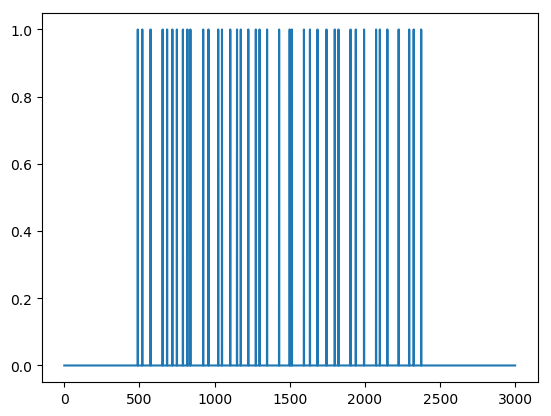

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f84ad167da0>

In [85]:
plot(rand_stimtimes)

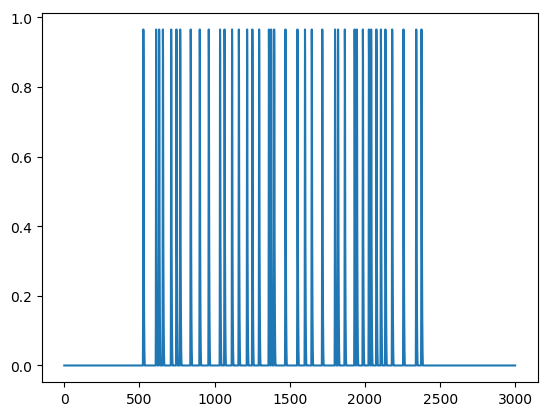

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f84ad51ab70>

In [39]:
zscore = zeros(size(raw))

for r = 1:size(raw)[1]
    trace = raw[r,:]
    avg = nanmean(trace[60:end])
    stdev = nanstd(trace[60:end])
    if (!isnan(avg) == true) && (!isnan(stdev) == true)
        if stdev > 0
            zscore[r,:] .= (trace .- avg) ./ stdev
        else
            zscore[r,:] .= (trace .- avg)
        end
    end
end

In [86]:
size(centroids)

(163229, 3)

In [88]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))
IJulia.clear_output()

0

### Detect block edges and stimulus times

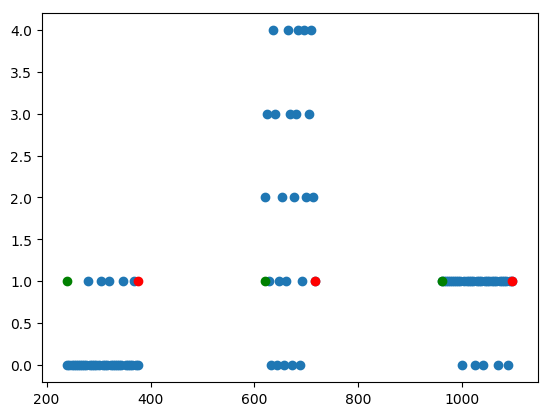

10-element Vector{Int64}:
  264
  312
  336
  344
  376
  976
  984
 1064
 1072
 1096

In [330]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > isi
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])
    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])

    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []
ms_f3_times = []
ms_f4_times = []
ms_f5_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    elseif curr_stim == 2
        append!(ms_f3_times,stimtimes[i])
    elseif curr_stim == 3
        append!(ms_f4_times,stimtimes[i])
    elseif curr_stim == 4
        append!(ms_f5_times,stimtimes[i])
    end
end

rng1 = Int(block_edges[1,1]):isi*2:Int(block_edges[1,2])
rng2 = Int(block_edges[3,1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)
rn2 = collect(rng2)
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

#offset_1 = sort(rand(r1,5))
offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)

In [329]:
stim_freqs

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [10]:
offset_1

function space_segments(times)
    for t = 1:length(times)-1
        dist = times[t+1] - times[t]
        if dist == isi
            times[t+1] += 4
        end
    end
    return times
end

test = space_segments(offset_1)


5-element Vector{Int64}:
 248
 272
 288
 296
 312

In [99]:
isi = 5

5

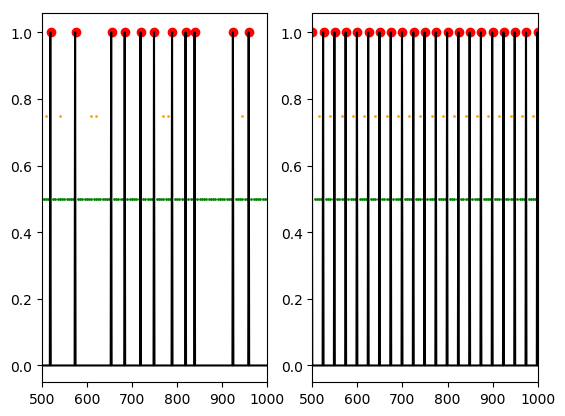

(500, 1000)

In [139]:

rand_gap_times = findall(rand_stimtimes[:,1] .== 1)
reg_gap_times = findall(reg_stimtimes[:,1] .== 1)
rng = rand_gap_times[1]-isi:isi:rand_gap_times[end]+isi
rand_noise_times = [reg_noise_times[1]-isi]

for t = 1:length(rand_gap_times)-1
    gi = rand_gap_times[t]
    next = rand_gap_times[t+1]
    for t2 = gi:isi:next-isi
        if rand_stimtimes[t2+isi] .== 0 append!(rand_noise_times,t2+isi) end
    end
end

reg_noise_times = [reg_gap_times[1]-isi]
for t = 1:length(reg_gap_times)-1
    gi = reg_gap_times[t]
    next = reg_gap_times[t+1]
    for t2 = gi:isi:next-isi
        if reg_stimtimes[t2+isi] .== 0 append!(reg_noise_times,t2+isi) end
    end
end

offset_reg_times = reg_gap_times .- isi*2
offset_rand_times = sample(rand_noise_times,length(rand_gap_times),replace=false)

all_stim_rand = vcat(rand_gap_times,rand_noise_times)
random_rand_times = sample(all_stim_rand,length(rand_gap_times),replace=false)

all_stim_reg = vcat(reg_gap_times,reg_noise_times)
random_reg_times = sample(all_stim_reg,length(reg_gap_times),replace=false)

# findall(rand_stimtimes[rng,1] .== 0).+(rand_gap_times[1]-isi)
subplot(121)
plot(rand_stimtimes[:,1],color="black")
scatter(rand_gap_times,rand_stimtimes[rand_gap_times],color="red")
scatter(rand_noise_times,rand_stimtimes[rand_noise_times].+0.5,color="green",s=1)
scatter(offset_rand_times,rand_stimtimes[offset_rand_times].+0.75,color="orange",s=1)
xlim(500,1000)

subplot(122)
plot(reg_stimtimes[:,1],color="black")
scatter(reg_gap_times,reg_stimtimes[reg_gap_times],color="red")
scatter(reg_noise_times,reg_stimtimes[reg_noise_times].+0.5,color="green",s=1)
scatter(offset_reg_times,reg_stimtimes[offset_reg_times].+0.75,color="orange",s=1)

xlim(500,1000)
#xlim(500,1500)

In [136]:
n_frames = length(reg_stimtimes[:,1])

3000

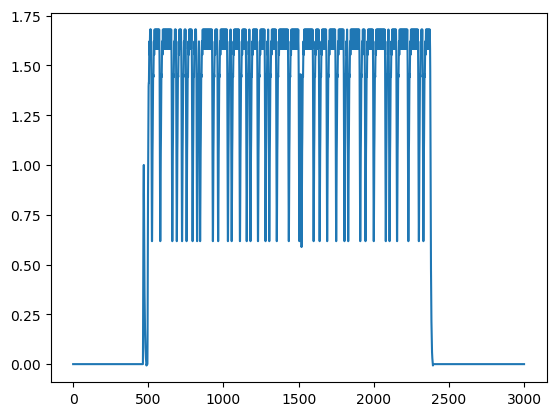

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f84abeb0eb8>

In [137]:
times = rand_noise_times
reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
plot(reg)
   # return reg

In [135]:
n_frames

1

### Compute regressors

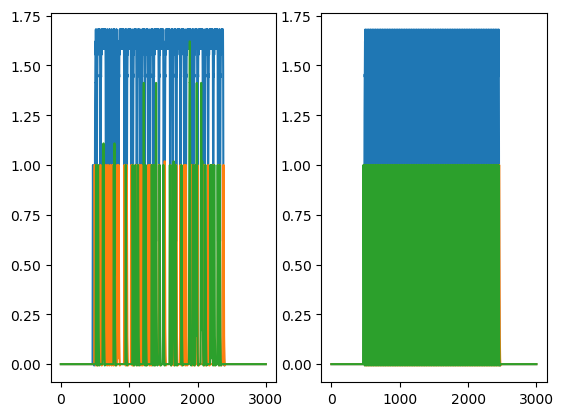

4-element Vector{String}:
 "auditory"
 "gap"
 "gap offset"
 "random"

In [147]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_rand_reg = compute_calcium(rand_noise_times)
gap_rand_reg = compute_calcium(rand_gap_times)
offset_rand_reg = compute_calcium(offset_rand_times)
random_rand_reg = compute_calcium(random_rand_times)

auditory_reg_reg = compute_calcium(reg_noise_times)
gap_reg_reg = compute_calcium(reg_gap_times)
offset_reg_reg = compute_calcium(offset_reg_times)
random_reg_reg = compute_calcium(random_reg_times)

subplot(121)
plot(auditory_rand_reg)
plot(gap_rand_reg)
plot(offset_rand_reg)

subplot(122)
plot(auditory_reg_reg)
plot(gap_reg_reg)
plot(offset_reg_reg)

exp_regs_rand = [auditory_rand_reg, gap_rand_reg, offset_rand_reg,random_rand_reg]
exp_regs_reg = [auditory_reg_reg, gap_reg_reg, offset_reg_reg,random_reg_reg]

reg_titles = ["auditory","gap","gap offset","random"]

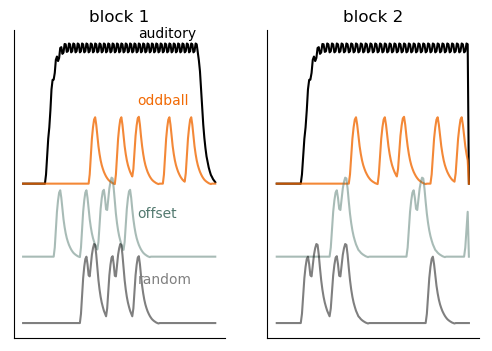

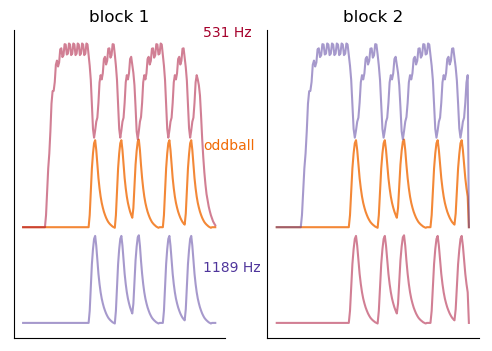

Any[]

In [12]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])
#text(xpos,-1.5,"random",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

In [160]:
total_rois = size(DF_rand[:,1])[1]

coeffs = Array{Float32}(undef,length(exp_regs_rand),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs_rand),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs_rand),total_rois); fill!(pvals,NaN)

rng = 500:2500
t = now()
print("starting $t ...")
for i = 1:total_rois
    reg_ctr = 1
    yr = DF_rand[i,:]
    for r = 1:length(exp_regs_rand)
        t = now()
        xr = exp_regs_rand[r]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s[reg_ctr,i] = r2(ols)
        coeffs[reg_ctr,i] = coef(ols)[2]
        pvals[reg_ctr,i] = coeftable(ols).cols[4][2]
        reg_ctr +=1
    end
end
t = now()
print("...complete $t")

starting 2024-02-29T14:57:02.542 ......complete 2024-02-29T14:58:52.312

In [158]:
total_rois

(163229,)

In [148]:
short_id = file_list[1][length(drv)+17:end-4]


""

In [161]:
#short_id = file_list[pnum][length(drv)+17:end-4]
short_id = "10hz_rand"
outfile = outpath*short_id*".h5"
if isfile(outfile) rm(outfile) end
of = h5open(outfile,"w")

for r=1:length(exp_regs_rand)
    create_group(of,reg_titles[r])
    of[reg_titles[r]]["reg"] = exp_regs_rand[r]
    of[reg_titles[r]]["r2"] = r2s[r,:]
    of[reg_titles[r]]["coef"] = coeffs[r,:]
    of[reg_titles[r]]["pval"] = pvals[r,:]
end

close(of)

In [ ]:
#short_id = file_list[pnum][length(drv)+17:end-4]
short_id = "10hz_rand"
outfile = outpath*short_id*".h5"
if isfile(outfile) rm(outfile) end
of = h5open(outfile,"w")

for r=1:length(exp_regs_rand)
    create_group(of,reg_titles[r])
    of[reg_titles[r]]["reg"] = exp_regs_rand[r]
    of[reg_titles[r]]["r2"] = r2s[r,:]
    of[reg_titles[r]]["coef"] = coeffs[r,:]
    of[reg_titles[r]]["pval"] = pvals[r,:]
end

close(of)

### Read in the data if you already have it

In [229]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

for r=1:length(exp_regs)
    #temp = of[reg_titles[r]]["r2"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
    push!(sig_rois, of[reg_titles[r]]["sig_rois"][])
    push!(nonsig_rois, of[reg_titles[r]]["nonsig_rois"][])
end
close(of)

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

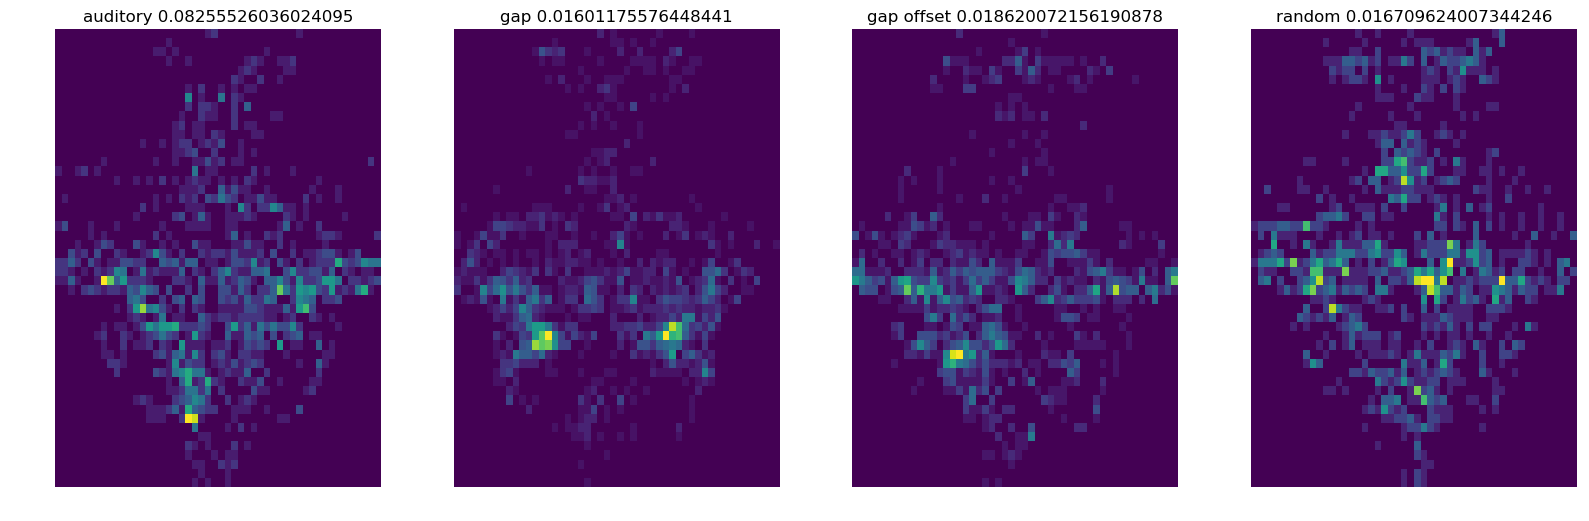

In [162]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=3,4
figure(figsize=(cols*4,rows*5)); 

alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.1
perc_cutoff = 99
for r=1:length(exp_regs_rand)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    #if perc_99 < minimum_r2 perc_99 = minimum_r2 end
    
    sig_roi_r2 = findall(r2s_clean .> perc_99); #idx_rest_r2 = findall(r2s_clean .<= percentile(r2s_clean,perc_99))
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
end

tight_layout()

In [231]:
no_overlap_sig = Array{Int64}[]
no_overlap_nonsig = Array{Int64}[]

exclude = copy(unique(vcat(sig_rois[9,:][1],sig_rois[10,:][1],sig_rois[5,:][1],sig_rois[6,:][1])))

for i in [7,8]
    sr = copy(sig_rois[i,:][1])
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in exclude) == true
            append!(del_idx,s)
        end
    end
    
    deleteat!(sr,del_idx)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sr)
    
    push!(no_overlap_sig,sr)
    push!(no_overlap_nonsig,nonsig_roi)
    
    push!(sig_rois,sr)
    push!(nonsig_rois,sr)
end

In [119]:
of = h5open(outfile,"r+")
##of["centroids"] = centroids
#of["idx_fish"] = idx_fish
for r=1:length(exp_regs)    
    #of[reg_titles[r]]["sig_rois"] = sig_rois[r,:][1]
    #of[reg_titles[r]]["nonsig_rois"] = nonsig_rois[r,:][1]
    labels = ["no_overlap_sig","no_overlap_nonsig"]
    for label in labels
        if haskey(of[reg_titles[r]],label) == true
            delete_object(of[reg_titles[r]][label])
        end
    end
    of[reg_titles[r]]["no_overlap_sig"] = sig_rois[r,:][1]
    of[reg_titles[r]]["no_overlap_nonsig"] = nonsig_rois[r,:][1]
end
#close(of)

In [16]:
n_fish = length(unique(idx_fish))

12

In [163]:
using PyCall
@pyimport matplotlib.colors as matcolors

bwr_black = matcolors.LinearSegmentedColormap.from_list("bwr_black", (
                 (0.000, (0.298, 0.443, 1.000)),
                 (0.250, (0.000, 0.145, 0.702)),
                 (0.500, (0.000, 0.000, 0.000)),
                 (0.750, (0.780, 0.012, 0.051)),
                 (1.000, (0.988, 0.290, 0.325))))

In [164]:
typeof(bwr_black)

ColorMap

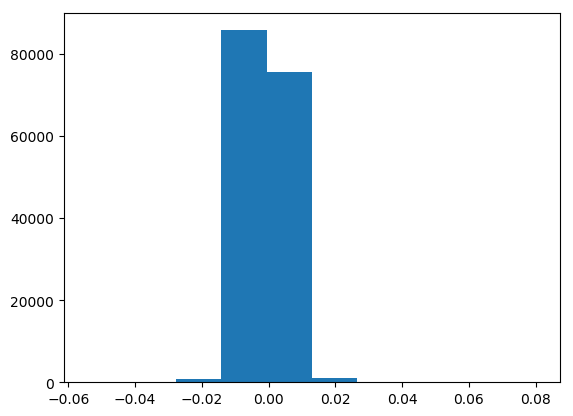

([8.0, 51.0, 708.0, 85766.0, 75564.0, 989.0, 117.0, 19.0, 4.0, 3.0], Float32[-0.054642297, -0.041136317, -0.027630337, -0.014124356, -0.00061837584, 0.012887605, 0.026393585, 0.039899565, 0.053405546, 0.066911526, 0.08041751], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f84ce31f7f0>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce31f5f8>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce31fe10>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce3281d0>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce328550>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce3288d0>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce328c50>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce328fd0>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce333390>, PyObject <matplotlib.patches.Rectangle object at 0x7f84ce333710>])

In [169]:
hist(vec(filter(!isnan,coeffs[3,:])))

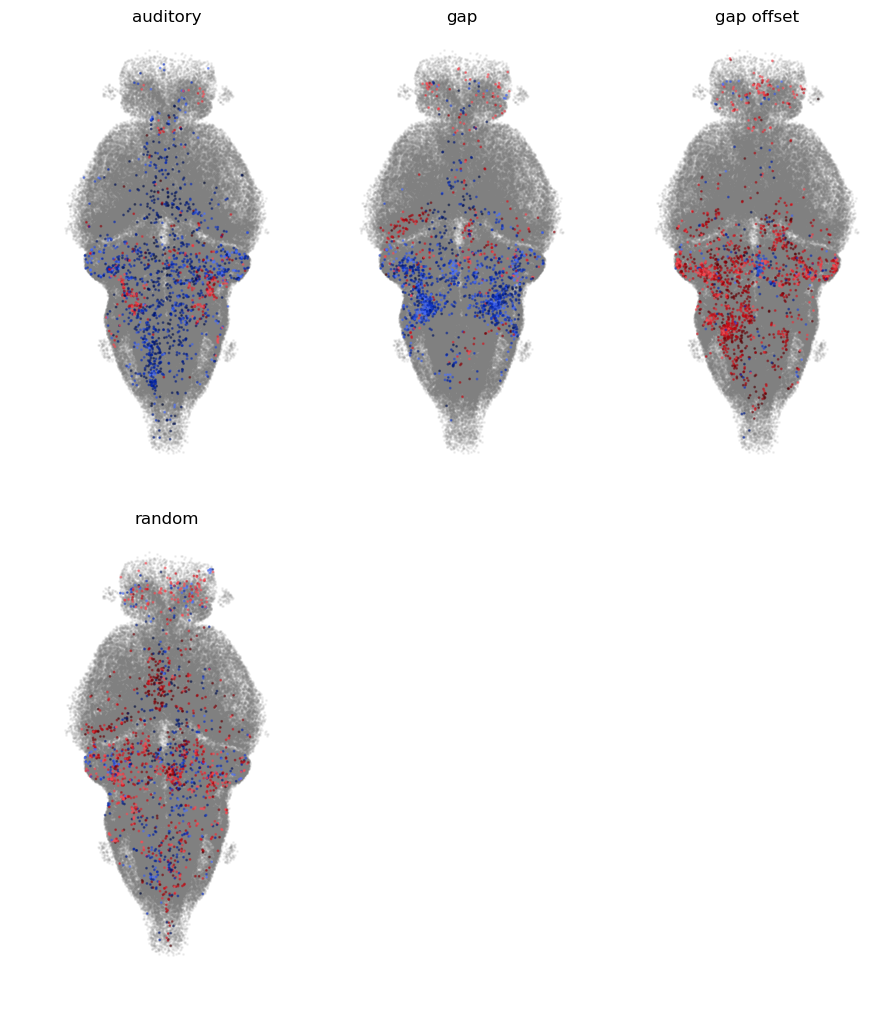

In [171]:
rows,cols=4,3
figure(figsize=(cols*3,rows*5)); 

vm = 0.02
r=1
for r=1:length(exp_regs_rand)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    subplot(rows,cols,r); axis("off")
    title(reg_titles[r])
    co = (coeffs[r,sr])
    scatter(centroids[nr,2],centroids[nr,1],color="gray",s=1,alpha=0.1)
    scatter(centroids[sr,2],centroids[sr,1],c=co,cmap=bwr_black,s=1,alpha=0.5,vmin=-vm,vmax=vm)
end

tight_layout()

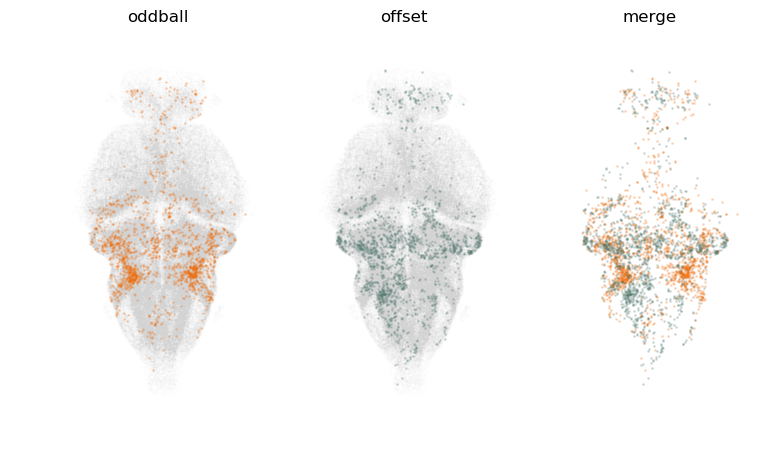

In [172]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["oddball","offset","merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[3,:][1]
sr2 = sig_rois[3,:][1]

nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ax3 = subplot(133); 
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

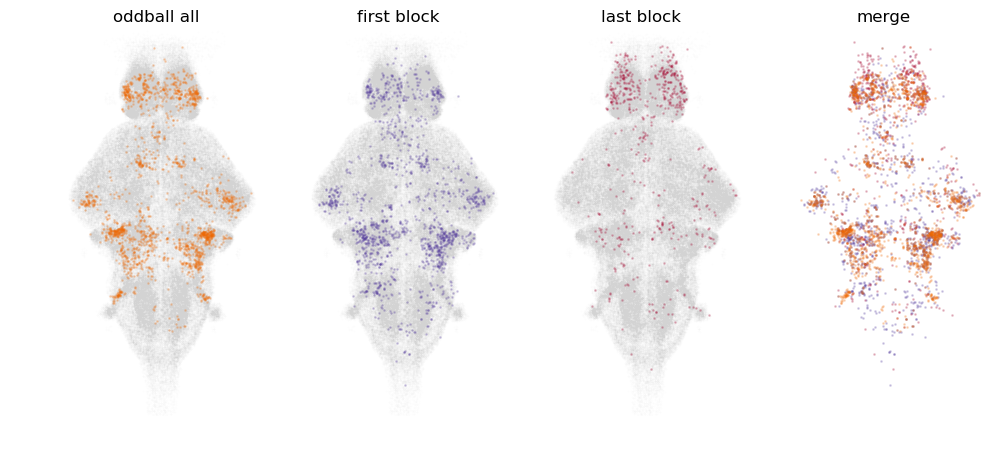

In [332]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["oddball all","first block","last block","merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]

nr2 = nonsig_rois[2,:][1]
sr2 = sig_rois[11,:][1]
nr3 = nonsig_rois[2,:][1]
sr3 = sig_rois[12,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

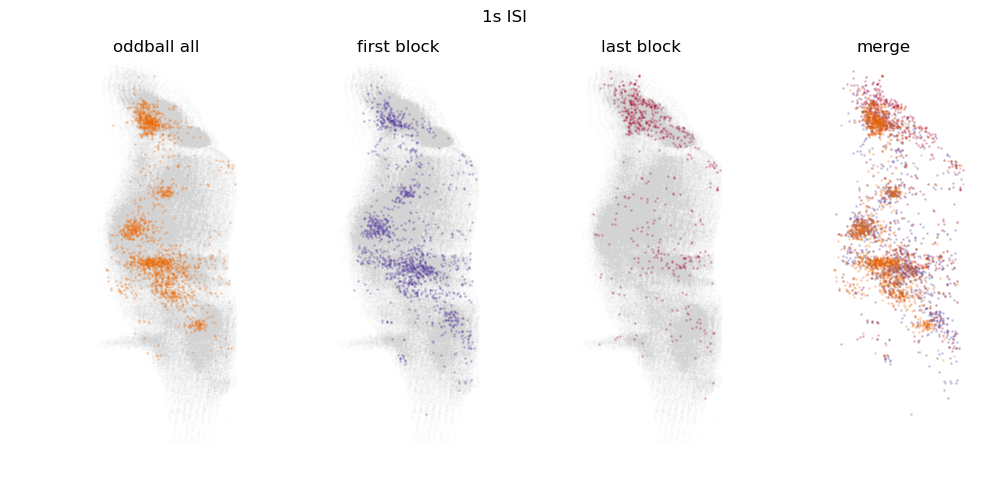

In [130]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["oddball all","first block","last block","merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]

nr2 = nonsig_rois[2,:][1]
sr2 = sig_rois[11,:][1]
nr3 = nonsig_rois[2,:][1]
sr3 = sig_rois[12,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,3],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,3],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,3],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,3],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,3],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,3],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,3],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[sr3,3],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr1,3],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,150)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

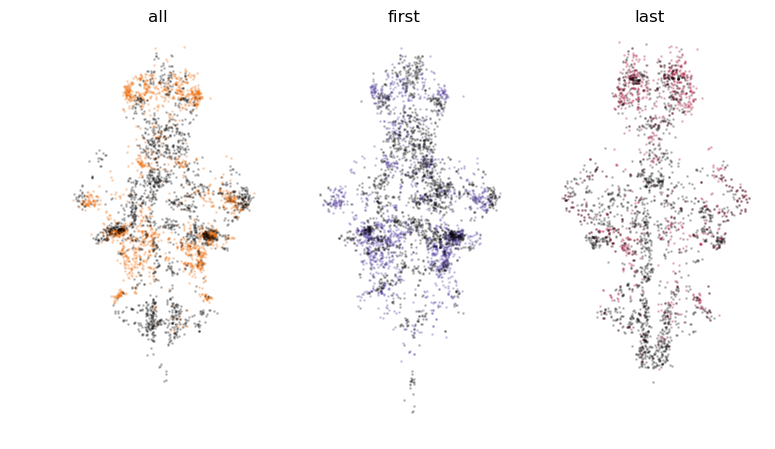

In [336]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["all","first","last","merge"]


sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[7,:][1]
sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]
sr3 = sig_rois[8,:][1]

osr1 = sig_rois[3,:][1]
onr1 = nonsig_rois[3,:][1]
onr2 = nonsig_rois[9,:][1]
osr2 = sig_rois[9,:][1]
onr3 = nonsig_rois[10,:][1]
osr3 = sig_rois[10,:][1]

ax1 = subplot(131); 
#scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr1,2],centroids[osr1,1],color="black",s=1,alpha=a)

ax2 = subplot(132);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[osr2,2],centroids[osr2,1],color="black",s=1,alpha=a)

ax3 = subplot(133);
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[osr3,2],centroids[osr3,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

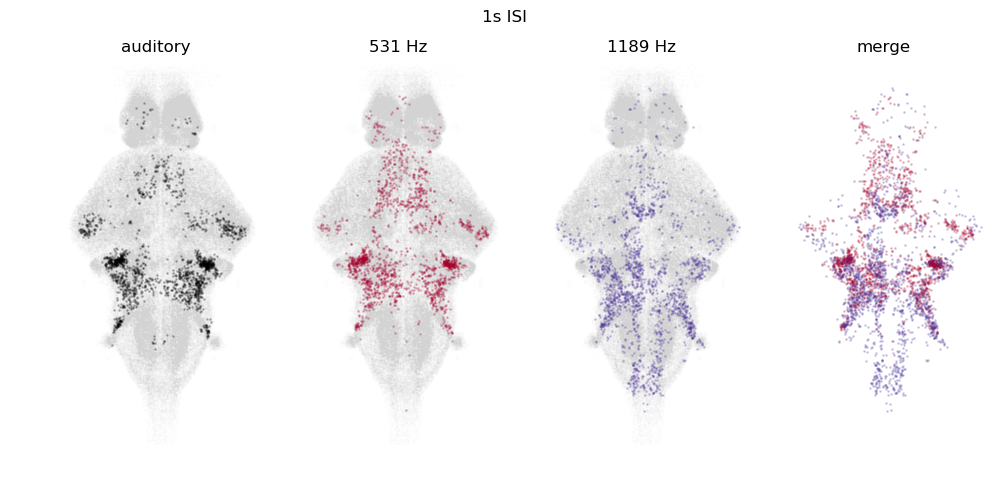

In [662]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["auditory","531 Hz","1189 Hz","merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)
#scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

## Motion analysis

In [140]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

# TODO: Regressor for block-specific motions

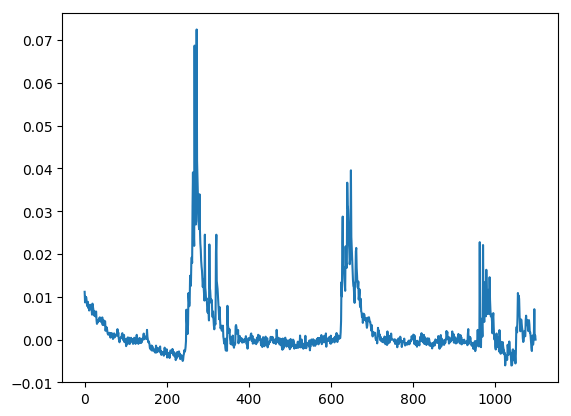

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa15d432c18>

In [541]:
plot(motion_reg[1][:])

In [551]:
mot_1_reg = zeros(n_fish,length(motion_reg[1][:]))
mot_2_reg = zeros(n_fish,length(motion_reg[1][:]))
for i = 1:n_fish
    for stim in oddball_1st
        mot_1_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
    
    for stim in oddball_2nd
        mot_2_reg[i,stim-1:stim+isi] = motion_reg[i][stim-1:stim+isi]
    end
end

In [561]:
coeffs_mot = Array{Float32}(undef,total_rois); fill!(coeffs_mot,NaN)
r2s_mot = Array{Float32}(undef,total_rois); fill!(r2s_mot,NaN)
pvals_mot = Array{Float32}(undef,total_rois); fill!(pvals_mot,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = motion_reg[f][:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot[i] = r2(ols)
        coeffs_mot[i] = coef(ols)[2]
        pvals_mot[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot1 = Array{Float32}(undef,total_rois); fill!(coeffs_mot1,NaN)
r2s_mot1 = Array{Float32}(undef,total_rois); fill!(r2s_mot1,NaN)
pvals_mot1 = Array{Float32}(undef,total_rois); fill!(pvals_mot1,NaN)

t = now()
print("starting $t ...")
for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_1_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot1[i] = r2(ols)
        coeffs_mot1[i] = coef(ols)[2]
        pvals_mot1[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

coeffs_mot2 = Array{Float32}(undef,total_rois); fill!(coeffs_mot2,NaN)
r2s_mot2 = Array{Float32}(undef,total_rois); fill!(r2s_mot2,NaN)
pvals_mot2 = Array{Float32}(undef,total_rois); fill!(pvals_mot2,NaN)

for f = 1:n_fish
    idx = findall(reset_idx_fish[1,:] .== f)
    xr = mot_2_reg[f,:]
    for i in idx
        yr = DF[i,:]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s_mot2[i] = r2(ols)
        coeffs_mot2[i] = coef(ols)[2]
        pvals_mot2[i] = coeftable(ols).cols[4][2]
    end
end
t = now()
print("...complete $t")

starting 2024-02-28T18:54:36.478 ......complete 2024-02-28T18:54:55.698starting 2024-02-28T18:54:55.699 ......complete 2024-02-28T18:55:14.678...complete 2024-02-28T18:55:33.589

### Compute motion-significant ROIs

In [448]:
pvals_clean = pvals_mot[:]
sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
r2s_clean = replace(r2s_mot[:],NaN=>0)
perc_99 = percentile(r2s_clean,90)
print(perc_99)
sig_roi_r2 = findall(r2s_clean .> perc_99)

sig_mot = intersect(sig_roi_pval,sig_roi_r2)
IJulia.clear_output()

0

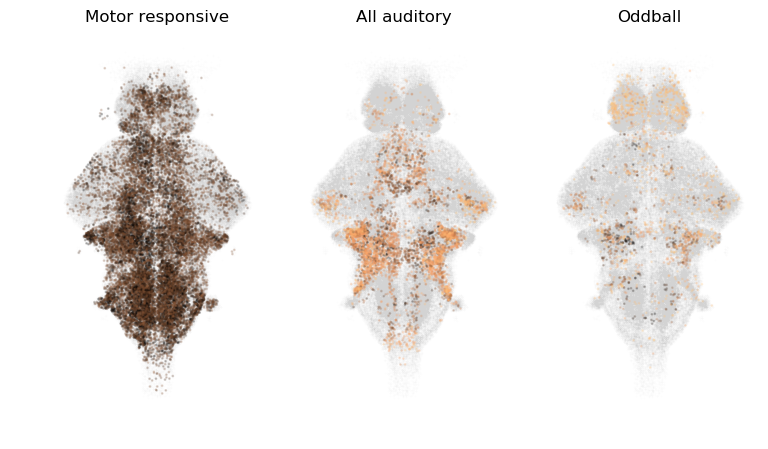

PyObject <matplotlib.collections.PathCollection object at 0x7fa15b3c0128>

In [455]:
figure(figsize=(9,5))

cm = "copper_r"
vm = 0.5

subplot(131); axis("off"); title("Motor responsive")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("Oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

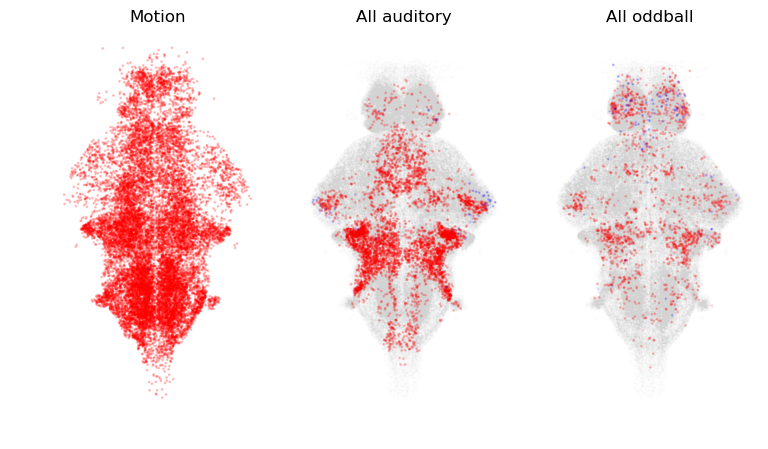

PyObject <matplotlib.collections.PathCollection object at 0x7fa15cea9a20>

In [534]:
figure(figsize=(9,5))

cm = "bwr"
vm = 0.5
subplot(131); axis("off"); title("Motion")
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=coeffs_mot[sig_mot],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("All auditory")
i = vcat(sig_rois[1,:][1],sig_rois[5,:][1],sig_rois[6,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("All oddball")
i = vcat(sig_rois[11,:][1],sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot[i],s=1,cmap=cm,vmin=-vm,vmax=vm,alpha=0.2)


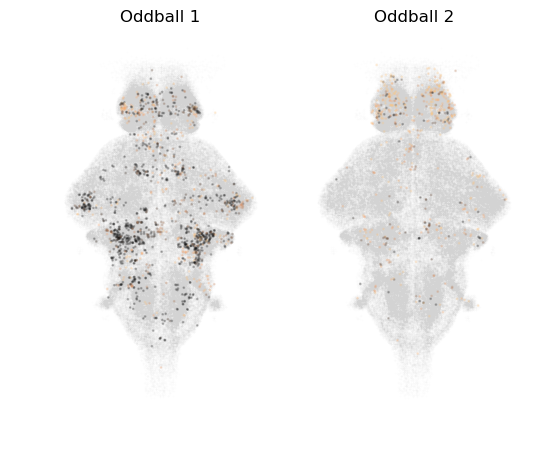

PyObject <matplotlib.collections.PathCollection object at 0x7fa15c712c50>

In [581]:
figure(figsize=(6,5))

cm = "copper_r"
vm = 0.05

subplot(121); axis("off"); title("Oddball 1")
i = vcat(sig_rois[11,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot1[i],s=1,cmap=cm,alpha=0.2,vmin=0,vmax=vm)

subplot(122); axis("off"); title("Oddball 2")
i = vcat(sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot2[i],s=1,cmap=cm,alpha=0.2,vmin=0,vmax=vm)

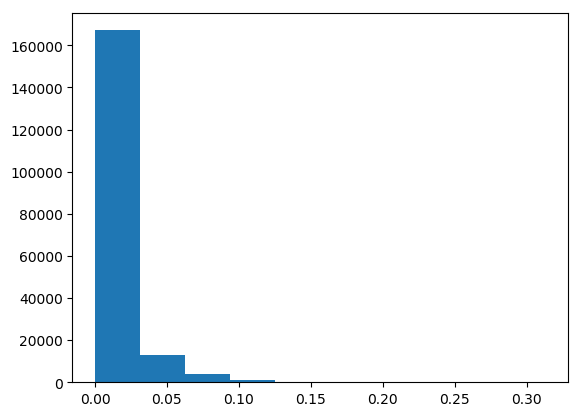

([167128.0, 12949.0, 3849.0, 1078.0, 338.0, 124.0, 35.0, 17.0, 8.0, 6.0], Float32[5.595524f-14, 0.031327747, 0.06265549, 0.09398323, 0.12531099, 0.15663873, 0.18796647, 0.21929422, 0.25062197, 0.2819497, 0.31327745], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7fa157c98a90>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157c98710>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157c98780>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15c668f28>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15c668a20>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15c668b70>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15c668160>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15cc09278>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15cc09748>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15cc09c88>])

In [578]:
hist(vec(filter(!isnan,r2s_mot1)))

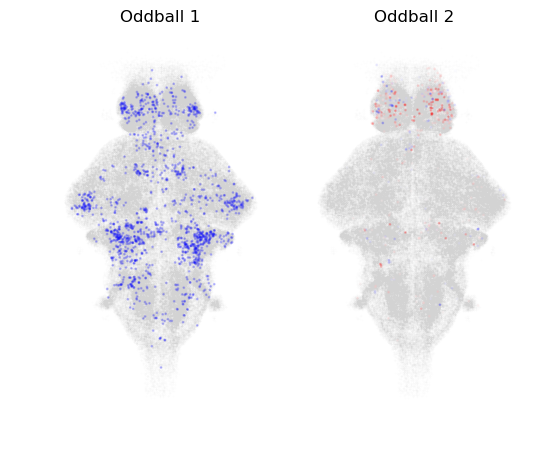

PyObject <matplotlib.collections.PathCollection object at 0x7fa15d25e0b8>

In [579]:
figure(figsize=(6,5))

cm = "copper_r"
vm = 10

subplot(121); axis("off"); title("Oddball 1")
i = vcat(sig_rois[11,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot1[i],s=1,cmap="bwr",alpha=0.2,vmin=vm,vmax=vm)

subplot(122); axis("off"); title("Oddball 2")
i = vcat(sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=coeffs_mot2[i],s=1,cmap="bwr",alpha=0.2,vmin=-vm,vmax=vm)

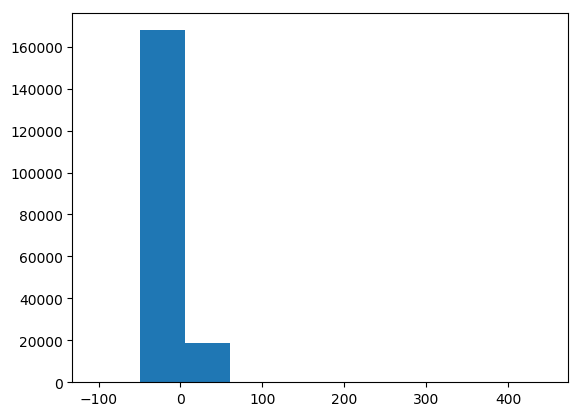

([11.0, 167808.0, 18588.0, 202.0, 39.0, 16.0, 9.0, 1.0, 0.0, 1.0], Float32[-104.27395, -49.258316, 5.757318, 60.772953, 115.78858, 170.80421, 225.81985, 280.83548, 335.8511, 390.86676, 445.8824], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7fa157ccf828>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157ccfdd8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157a5e080>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157a5e4e0>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157a5ec18>, PyObject <matplotlib.patches.Rectangle object at 0x7fa157a5eb38>, PyObject <matplotlib.patches.Rectangle object at 0x7fa1588029e8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa158802320>, PyObject <matplotlib.patches.Rectangle object at 0x7fa1588026a0>, PyObject <matplotlib.patches.Rectangle object at 0x7fa15b28bba8>])

In [574]:
hist(vec(filter(!isnan,coeffs_mot1)))

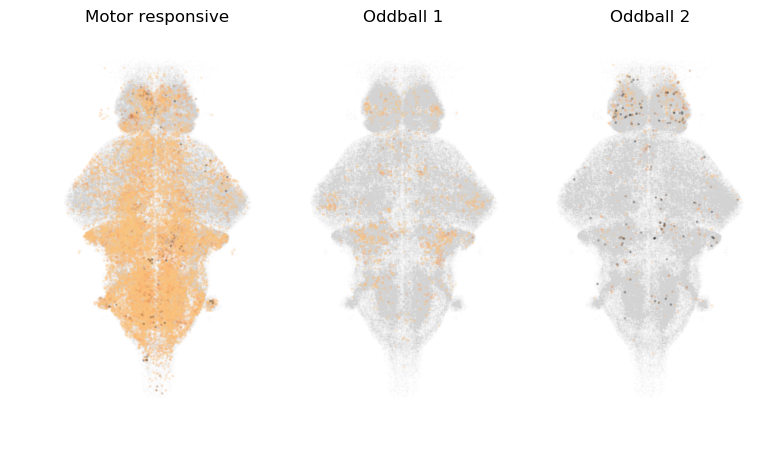

PyObject <matplotlib.collections.PathCollection object at 0x7fa11cdf9748>

In [562]:
figure(figsize=(9,5))

cm = "copper_r"
vm = 0.05

subplot(131); axis("off"); title("Motor responsive")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sig_mot,2],centroids[sig_mot,1],c=r2s_mot2[sig_mot],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(132); axis("off"); title("Oddball 1")
i = vcat(sig_rois[11,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot2[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

subplot(133); axis("off"); title("Oddball 2")
i = vcat(sig_rois[12,:][1])
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[i,2],centroids[i,1],c=r2s_mot2[i],s=1,cmap=cm,vmin=0,vmax=vm,alpha=0.2)

In [558]:
r2s_mot1

186675-element Vector{Float32}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

### Plot all individual traces + oddball cells from each fish

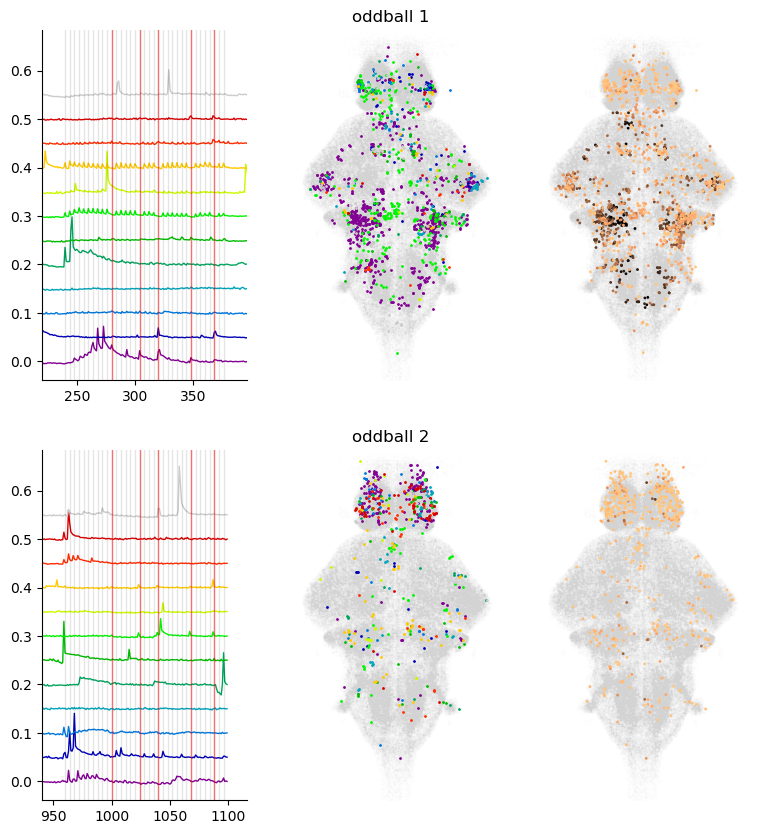

In [247]:
ctr = 0
cm = PyPlot.cm.get_cmap("nipy_spectral")
cm_r2 = "copper_r"
vm = 0.5

rows,cols = 2,3
figure(figsize=(cols*3,rows*5))
ax1 = subplot(rows,cols,1)
ax2 = subplot(rows,cols,2)
ax3 = subplot(rows,cols,3)
ax4 = subplot(rows,cols,4)
ax5 = subplot(rows,cols,5)
ax6 = subplot(rows,cols,6)

n_fish = size(motion_reg)[1]
subplot(rows,cols,1)
for i = 1:n_fish
    plot(motion_reg[i][:].+ctr,color=cm(i/n_fish),linewidth=1)
    ctr+=0.05
end

for s in stimtimes
   axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end

for s in oddball_times
   axvline(s,0,1,color="red",linewidth=1,alpha=0.5) 
end

xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

sr1 = sig_rois[11,:][1]
subplot(rows,cols,2); axis("off"); title("oddball 1")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],c=cm(i/n_fish),s=1,cmap=cm)    
end

subplot(rows,cols,3)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=r2s_mot[sr1],s=1,cmap=cm_r2,vmin=0,vmax=vm)

subplot(rows,cols,4)
n_fish = size(motion_reg)[1]
ctr = 0
for i = 1:n_fish
    plot(motion_reg[i][:].+ctr,color=cm(i/n_fish),linewidth=1)
    ctr+=0.05
end

for s in stimtimes
   axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end

for s in oddball_times
   axvline(s,0,1,color="red",linewidth=1,alpha=0.5) 
end

xlim(block_edges[3,1]-fps*5,block_edges[3,2]+fps*5)

sr1 = sig_rois[12,:][1]
subplot(rows,cols,5); title("oddball 2")
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],c=cm(i/n_fish),s=1,cmap=cm)    
end

subplot(rows,cols,6)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=r2s_mot[sr1],s=1,cmap=cm_r2,vmin=0,vmax=vm)

for ax in [ax2,ax3,ax5,ax6]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
end

for ax in [ax1,ax4]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

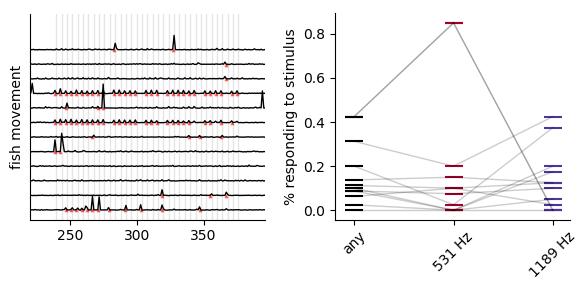

In [460]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*3,rows*3))


ax1 = subplot(rows,cols,1)
yticks([])
for s in stimtimes
    axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end
ylabel("fish movement")
xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

ax2 = subplot(rows,cols,2)
ylabel("% responding to stimulus")
xticks([1,2,3],["any","531 Hz","1189 Hz"],rotation=45)

i =1
for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0

    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    plot(signal.+ctr,color="black",linewidth=1)
    for s in vcat(f1_times,f2_times)
        total_stim += 1
        segment = signal[s-1:s+2]
        if maximum(segment) > 0.005
            responses += 1
            idx = findall(segment .== maximum(segment))[1]
            scatter(s-1,-0.001.+ctr,color="red",marker="^",s=3,alpha=0.5)
            
            if s in f1_times
                f1_resp += 1
            end
            if s in f2_times
                f2_resp += 1
            end
            
        end
    end
    ctr+=0.05

    subplot(rows,cols,2)
    scatter(1,responses/total_stim,color="black",marker="_",s=150)
    scatter(2,f1_resp/40,color=colors[3],marker="_",s=150)
    scatter(3,f2_resp/40,color=colors[4],marker="_",s=150)
    
    plot([1,2],[responses/total_stim,f1_resp/40],color="black",linewidth=1,alpha=0.2)
    plot([2,3],[f1_resp/40,f2_resp/40],color="black",linewidth=1,alpha=0.2)

end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

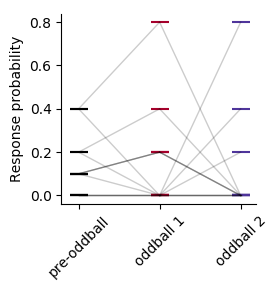

In [496]:
i = 7
ctr = 0
rows,cols = 1,2
figure(figsize=(cols*2.5,rows*3))


#ax1 = subplot(rows,cols,1)
#yticks([])
#for s in stimtimes
#    axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
#end
#ylabel("fish movement")
#xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)

ax2 = subplot(rows,cols,1)
ylabel("Response probability")
xticks([1,2,3],["pre-oddball","oddball 1","oddball 2"],rotation=45)

reference_stim = vcat(oddball_times,ms_f1_times,ms_f2_times)

pre_all = []
f1_all = []
f2_all = []

ob1_resp = zeros(n_fish,length(oddball_1st))
ob2_resp = zeros(n_fish,length(oddball_2nd))

for i = 1:n_fish
    total_stim, responses, f1_resp, f2_resp = 0,0,0,0
    subplot(rows,cols,1)
    signal = diff(motion_reg[i][:])
    signal[signal.<-0.001] .= 0
    ob1_n = 0
    ob2_n = 0
    for s in vcat(oddball_1st,oddball_2nd)#stimtimes[1:end-1]
        segment = signal[s-1:s+2]
        sp = s - isi
        pre_segment = signal[sp-1:sp+2]
        total_stim +=1 
        if s in oddball_1st 
            ob1_n +=1 
        end
        if s in oddball_2nd 
            ob2_n +=1 
        end
        if maximum(segment) > 0.005
            idx = findall(segment .== maximum(segment))[1]
            responses += 1
            if s in oddball_1st
                f1_resp += 1
                ob1_resp[i,ob1_n] = 1
            end
            if s in oddball_2nd
                f2_resp += 1
                ob2_resp[i,ob2_n] = 1
            end     
        end
    end
    ctr+=0.05

    f1_resp = f1_resp/5
    f2_resp = f2_resp/5
    responses = responses/total_stim
    
    push!(pre_all,responses)
    push!(f1_all,f1_resp)
    push!(f2_all,f2_resp)
    
    subplot(rows,cols,1)
    
    scatter(1,responses,color="black",marker="_",s=150)
    scatter(2,f1_resp,color=colors[3],marker="_",s=150)
    scatter(3,f2_resp,color=colors[4],marker="_",s=150)
    
    plot([1,2],[responses,f1_resp],color="black",linewidth=1,alpha=0.2)
    plot([2,3],[f1_resp,f2_resp],color="black",linewidth=1,alpha=0.2)
end

for ax in [ax1,ax2]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

In [491]:
f2_resp

0.2

In [499]:
ob1_resp[1,:]

5-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0

### Response probability by centroid

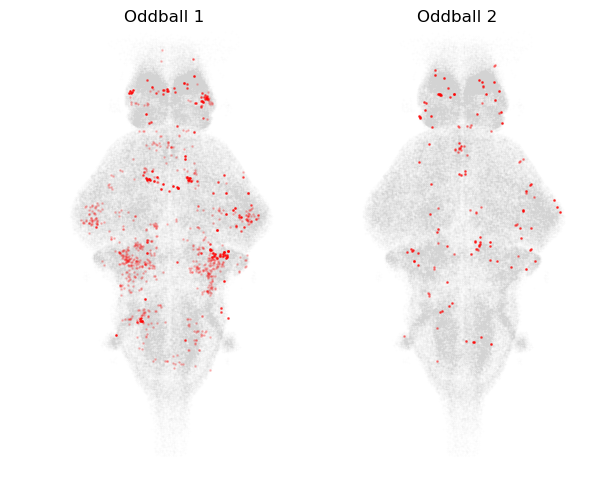

In [533]:
rows,cols = 1,2
figure(figsize=(cols*3,rows*5))

ax1 = subplot(rows,cols,1)
ax2 = subplot(rows,cols,2)
#ax3 = subplot(rows,cols,3)
#ax4 = subplot(rows,cols,4)
#ax5 = subplot(rows,cols,5)
#ax6 = subplot(rows,cols,6)

sr1 = sig_rois[11,:][1]

subplot(rows,cols,1)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

function plot_df_resp(idx,c_idx,y,color)
    if length(idx) > 0
        rngs = zeros(length(idx),2)
        y2 = []
        for i in idx
            append!(y2,y[oddball_2nd[i]:oddball_2nd[i]+2])
        end
        c = mean(y2)./maximum(y2)
        scatter(centroids[c_idx,2],centroids[c_idx,1],color=color,s=1,alpha=c)
    end
end

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    y = DF[c_idx,:]

    #idx = findall(ob1_resp[i,:] .== 0)
    #plot_df_resp(idx,c_idx,y,"blue")
    
    idx = findall(ob1_resp[i,:] .== 1)
    plot_df_resp(idx,c_idx,y,"red")

end

subplot(rows,cols,2)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

sr1 = sig_rois[12,:][1]
for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    y = DF[c_idx,:]
    idx = findall(ob2_resp[i,:] .== 1)
    plot_df_resp(idx,c_idx,y,"red")
    
    #idx = findall(ob1_resp[i,:] .== 0)
    #plot_df_resp(idx,c_idx,y,"blue")
end

titles = ["Oddball 1","Oddball 2"]
ctr = 1
for ax in [ax1,ax2]
    ax.set_title(titles[ctr])
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

tight_layout()

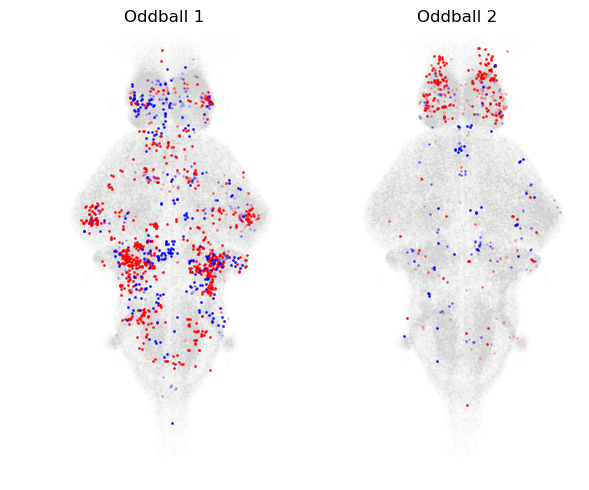

In [485]:
rows,cols = 1,2
figure(figsize=(cols*3,rows*5))

ax1 = subplot(rows,cols,1)
ax2 = subplot(rows,cols,2)
#ax3 = subplot(rows,cols,3)
#ax4 = subplot(rows,cols,4)
#ax5 = subplot(rows,cols,5)
#ax6 = subplot(rows,cols,6)

sr1 = sig_rois[11,:][1]

subplot(rows,cols,1)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)

for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],color="red",s=1,alpha=f1_all[i])    
    scatter(centroids[c_idx,2],centroids[c_idx,1],color="blue",s=1,alpha=f2_all[i])  
end

subplot(rows,cols,2)
scatter(centroids[:,2],centroids[:,1],c="lightgray",s=1,alpha=nsa)
sr1 = sig_rois[12,:][1]
for i = 1:n_fish
    c_idx = intersect(sr1,findall(reset_idx_fish[1,:] .== i))
    scatter(centroids[c_idx,2],centroids[c_idx,1],color="red",s=1,alpha=f1_all[i])    
    scatter(centroids[c_idx,2],centroids[c_idx,1],color="blue",s=1,alpha=f2_all[i])  
end

titles = ["Oddball 1","Oddball 2"]
ctr = 1
for ax in [ax1,ax2]
    ax.set_title(titles[ctr])
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

tight_layout()

## Figure 1 - all dF/F with stimulus times

In [409]:
n_timepoints = length(DF[1,:])

1100

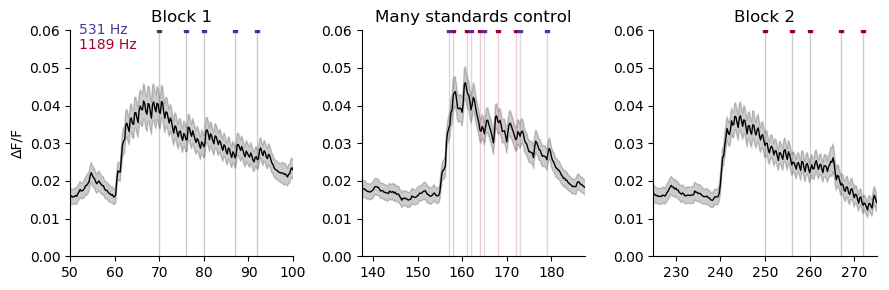

In [419]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.06

for t = 1:3
ctr = 3

x = collect(1:n_timepoints)./fps   

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    #for r in [5,6]
        #sr = sig_rois[r,:][1]
        #nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[:,:],dims=1))
        stdev = vec(std(DF[:,:],dims=1))./n_fish
        axes[t].fill_between(x, avg.-stdev, avg.+stdev,color="black",alpha=0.2,edgecolor="white")
        plot(x,avg,color="black",linewidth=1)
        ctr+=1
    #end

end

subplot(131); title("Block 1")
ylabel("ΔF/F")
text(52,ymax-0.001,"531 Hz",color=colors[4])
text(52,ymax-0.005,"1189 Hz",color=colors[3])

for ob in oddball_1st
    scatter(ob./fps,ymax,color=colors[4],marker="s",s=5)
end

xlim(200/fps,400/fps)

subplot(132); title("Many standards control")
for ob in ms_f1_times
    axvline(ob./fps,0,1,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob./fps,ymax,color=colors[3],marker="s",s=5)
end

for ob in ms_f2_times
    axvline(ob./fps,0,1,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob./fps,ymax,color=colors[4],marker="s",s=5)
end

xlim(550/fps,750/fps)

subplot(133); title("Block 2")

for ob in oddball_2nd
    scatter(ob./fps,ymax,color=colors[3],marker="s",s=5)
end
xlim(900/fps,1100/fps)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    for ob in oddball_times
        ax.axvline(ob./fps,0,1,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()

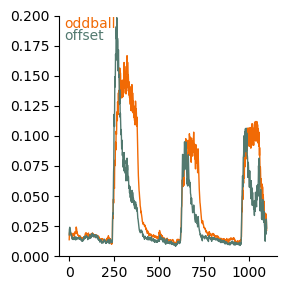

In [269]:
figure(figsize=(3,3))
ctr = 1
ax = subplot(111)
titles = ["oddball","offset"]
for r in [2,3]
    sr = sig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))
    plot(avg,color=colors[ctr],linewidth=1)
    text(-30,0.2-(ctr*0.01),titles[ctr],color=colors[ctr])
    ctr+=1 
end

ctr = 1
ax.set_ylim(0,0.2)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

tight_layout()

### Oddball/offset with block edges subplots

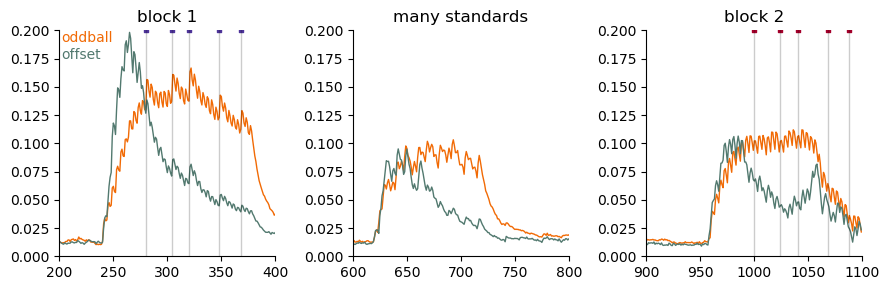

In [128]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

for t = 1:3
ctr = 1

subplot(1,3,t)
    for r in [2,3]
        #subplot(1,2,ctr)
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        #avg_n = vec(mean(DF[nr,:],dims=1))
        #plot(avg_n,color=colors[ctr],linewidth=1,alpha=0.5)
        plot(avg,color=colors[ctr],linewidth=1)
        
        ctr+=1
    end

end

subplot(131); title("block 1")
text(202,0.19,"oddball",color=colors[1])
text(202,0.175,"offset",color=colors[2])

for ob in oddball_1st
    scatter(ob,ymax,color=colors[4],marker="s",s=5)
end
xlim(200,400)

subplot(132); title("many standards")
xlim(600,800)

subplot(133); title("block 2")

for ob in oddball_2nd
    scatter(ob,ymax,color=colors[3],marker="s",s=5)
end
xlim(900,1100)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    for ob in oddball_times
        ax.axvline(ob,0,1,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()

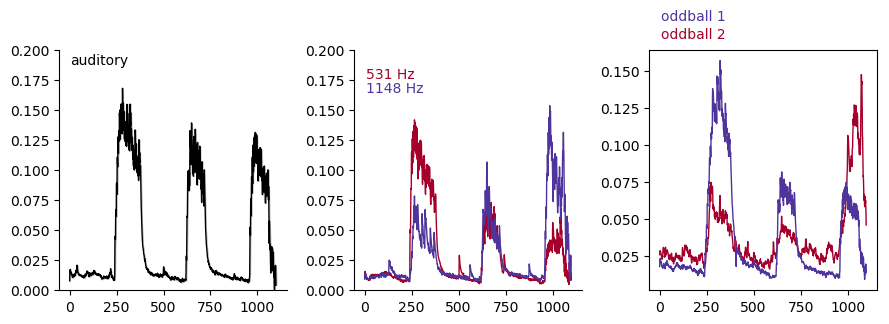

In [408]:
#figure(figsize=(10,10)); 
#rows,cols=4,3

figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ctr = 1
cctr = 3
titles = ["auditory","531 Hz","1148 Hz"]

subplot(131)
r = 1
sr = sig_rois[r,:][1]
avg = vec(mean(DF[sr,:],dims=1))
stdev = vec(std(DF[sr,:],dims=1))./length(sr)
plot(avg,color="black",linewidth=1)
ax1.fill_between(collect(1:length(avg)), avg.-stdev, avg.+stdev,color="black",alpha=0.2,edgecolor="none")
text(5,0.2.-(ctr*0.012),titles[ctr],color="black")
ctr+=1


subplot(132)
for r in [5,6]
    #subplot(1,2,ctr)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))
    plot(avg,color=colors[cctr],linewidth=1)
    text(5,0.2.-(ctr*0.012),titles[ctr],color=colors[cctr])
    ctr+=1
    cctr+=1
end


ctr = 1
cctr = 3
titles = ["oddball 2","oddball 1"]
subplot(133)
for r in [12,11]
    #subplot(1,2,ctr)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))
    plot(avg,color=colors[cctr],linewidth=1)
    text(5,0.16.+(ctr*0.012),titles[ctr],color=colors[cctr])
    ctr+=1
    cctr+=1
end

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(0,0.2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ctr+=1
end

tight_layout()

### Maximum change in dF/F for all frequencies

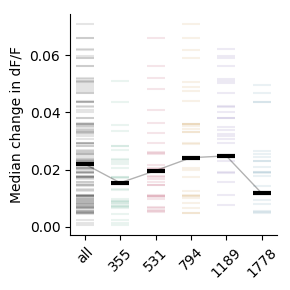

In [401]:
figure(figsize=(3,3))
ax = subplot(111)
titles = ["auditory","531 Hz","1189 Hz"]
col2 = ["black",colors[3],colors[4]]

r = 1

function max_df_change(sr,times)
    avg_all = []
    for stim in times
        y = DF[sr,stim:stim+isi]
        avg = median(y[2:end].- y[1])
        if avg > 0 append!(avg_all,avg) end
        #append!(avg_all,avg)
    end
    return avg_all
end

totals = zeros((6))

for fish in unique(idx_fish)
    ctr = 1
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[1,:][1]
    sr = intersect(sr,valid_idx)

    avg_all = max_df_change(sr,vcat(ms_f1_times,ms_f2_times,ms_f3_times,ms_f4_times,ms_f5_times))
    avg_f1 = max_df_change(sr,ms_f1_times)
    avg_f2 = max_df_change(sr,ms_f2_times)
    avg_f3 = max_df_change(sr,ms_f3_times)
    avg_f4 = max_df_change(sr,ms_f4_times)
    avg_f5 = max_df_change(sr,ms_f5_times)

    col2 = ["black",[55,151,113]./255,colors[3],[191,124,25]./255,colors[4],[54,118,152]./255]
    ctr = 1
    for avgs in [avg_all,avg_f3,avg_f1,avg_f4,avg_f2,avg_f5]
        try
        for avg in avgs 
            scatter(ctr,avg,color=col2[ctr],marker="_",s=150,alpha=0.1)
        end
            
        #scatter(ctr,mean(avgs),color=col2[ctr],marker="_",s=150,alpha=0.1)

        totals[ctr] += mean(avgs)
        catch
            continue
        end
        ctr+=1
    end
end
    
totals = totals./n_fish
for i = 1:6
    scatter(i,totals[i],color="black",marker="_",s=150,linewidth=3)
    if i < 6
        plot([i,i+1],[totals[i],totals[i+1]],color="black",linewidth=1,alpha=0.3)
    end
end

#ylim(-0.15,0.1)
#ylim(0,0.1)

#ax.set_xlim(0.5,3.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ylabel("Median change in dF/F")
xticks(collect(1:6),vcat(["all"],sort(Int.(stim_freqs))),rotation = 45)

tight_layout()

In [378]:
stim_freqs



LoadError: UndefVarError: avg_f3 not defined

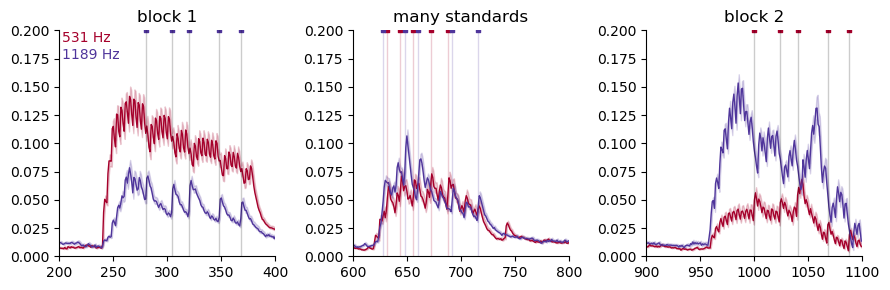

In [257]:

figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.2

for t = 1:3
ctr = 3

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    for r in [5,6]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        axes[t].fill_between(collect(1:length(avg)), avg.-stdev, avg.+stdev,color=colors[ctr],alpha=0.2)
        plot(avg,color=colors[ctr],linewidth=1)
        ctr+=1
    end

end

subplot(131); title("block 1")
text(202,0.19,"531 Hz",color=colors[3])
text(202,0.175,"1189 Hz",color=colors[4])

for ob in oddball_1st
    scatter(ob,ymax,color=colors[4],marker="s",s=5)
end

xlim(200,400)

subplot(132); title("many standards")
for ob in ms_f1_times
    axvline(ob,0,1,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob,ymax,color=colors[3],marker="s",s=5)
end

for ob in ms_f2_times
    axvline(ob,0,1,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob,ymax,color=colors[4],marker="s",s=5)
end

xlim(600,800)

subplot(133); title("block 2")

for ob in oddball_2nd
    scatter(ob,ymax,color=colors[3],marker="s",s=5)
end
xlim(900,1100)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    for ob in oddball_times
        ax.axvline(ob,0,1,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()

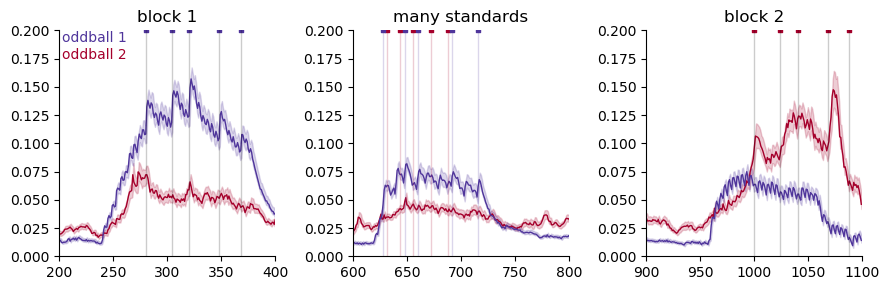

In [126]:

figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

ymax = 0.2

titles = ["oddball","offset"]

for t = 1:3
ctr = 3

axes = [ax1,ax2,ax3]
subplot(1,3,t)
    for r in [12,11]
        sr = sig_rois[r,:][1]
        nr = nonsig_rois[r,:][1]
        avg = vec(mean(DF[sr,:],dims=1))
        stdev = vec(std(DF[sr,:],dims=1))./n_fish
        axes[t].fill_between(collect(1:length(avg)), avg.-stdev, avg.+stdev,color=colors[ctr],alpha=0.2)
        plot(avg,color=colors[ctr],linewidth=1)
        ctr+=1
    end

end

subplot(131); title("block 1")
text(202,0.19,"oddball 1",color=colors[4])
text(202,0.175,"oddball 2",color=colors[3])

for ob in oddball_1st
    scatter(ob,ymax,color=colors[4],marker="s",s=5)
end

xlim(200,400)

subplot(132); title("many standards")
for ob in ms_f1_times
    axvline(ob,0,1,color=colors[3],linewidth=1,alpha=0.2)
    scatter(ob,ymax,color=colors[3],marker="s",s=5)
end

for ob in ms_f2_times
    axvline(ob,0,1,color=colors[4],linewidth=1,alpha=0.2)
    scatter(ob,ymax,color=colors[4],marker="s",s=5)
end

xlim(600,800)

subplot(133); title("block 2")

for ob in oddball_2nd
    scatter(ob,ymax,color=colors[3],marker="s",s=5)
end
xlim(900,1100)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,ymax)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    for ob in oddball_times
        ax.axvline(ob,0,1,color="black",linewidth=1,alpha=0.2)
    end
end

tight_layout()

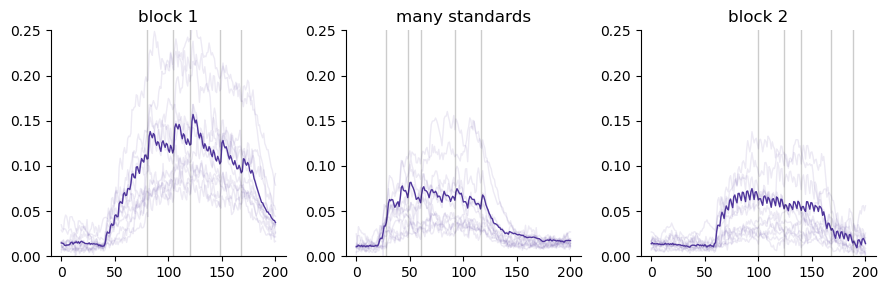

In [129]:
#figure(figsize=(10,10)); 
#rows,cols=4,3

figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

#nr1 = nonsig_rois[10,:][1]; sr1 = sig_rois[10,:][1]
#nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]
#nr3 = nonsig_rois[9,:][1]; sr3 = sig_rois[9,:][1]

r = 11
r2 = 9
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in or) == true
            append!(del_idx,s)
        end
    end
    
    deleteat!(sr,del_idx)
    
    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[4],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = sig_rois[r,:][1]
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[4],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f2_times[(f2_times .> rngs[t]) .&& (f2_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

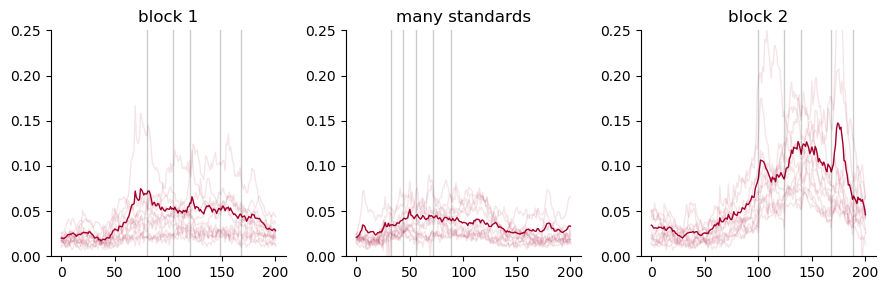

In [130]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

r = 12
r2 = 10
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in or) == true
            append!(del_idx,s)
        end
    end
    
    #print(length(del_idx),"\n")
    deleteat!(sr,del_idx)
    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[3],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = sig_rois[r,:][1]
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[3],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f1_times[(f1_times .> rngs[t]) .&& (f1_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

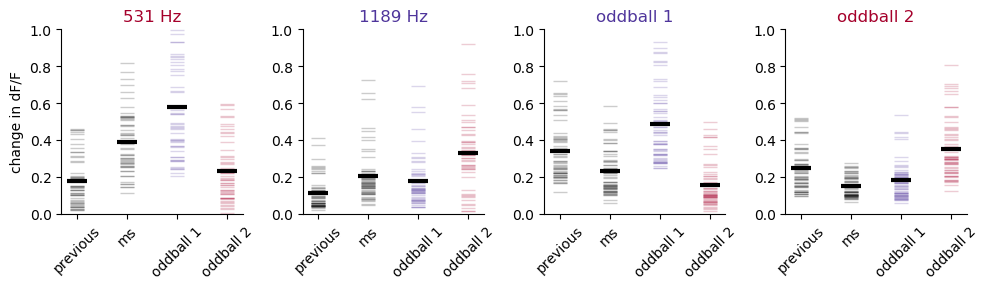

In [119]:
r = 11

rows,cols = 1,4

figure(figsize=(cols*2.5,rows*3))

ax1 = subplot(rows,cols,1)
ylabel("change in dF/F")
ax2 = subplot(rows,cols,2)
ax3 = subplot(rows,cols,3)
ax4 = subplot(rows,cols,4)

stim_freq = [0,1,1,0]
ms_times = [ms_f1_times,ms_f2_times,ms_f2_times,ms_f1_times]
c_ctr = 1
    avgs = zeros((4,2))

for r in [5,6,11,12]
    avgs = zeros((4,2))

    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[r,:][1]
        df_per_fish = intersect(sr,valid_idx)

        subplot(rows,cols,c_ctr)
        for t in 2:length(stimtimes)
            onset = stimtimes[t]
            response = vec(mean(DF[df_per_fish,onset:onset+isi],dims=1))
            response = sum(response) .- response[1]
            if stim_seq[t] .== stim_freq[c_ctr]
                if (stimtimes[t] in oddball_times)
                    resp = vec(mean(DF[df_per_fish,onset-isi:onset-1],dims=1))
                    resp = sum(resp) .- resp[1]
                    if (isnan(resp) == false)
                        avgs[1,1] += 1
                        avgs[1,2] += resp
                    end
                    scatter(1,resp,linewidth=1,alpha=0.2,color="black",marker="_",s=100)
                elseif ((onset in oddball_times) .== false) .&& ((onset in ms_times[c_ctr]) .== true)
                    scatter(2,response,linewidth=1,alpha=0.2,color="black",marker="_",s=100)
                    if (isnan(response) == false)
                        avgs[2,1] += 1
                        avgs[2,2] += response
                    end
                end
            end
            
            if (stimtimes[t] in oddball_1st) == true
                scatter(3,response,linewidth=1,alpha=0.2,color=colors[4],marker="_",s=100)
                if (isnan(response) == false)
                    avgs[3,1] += 1
                    avgs[3,2] += response
                end
            end
            
            if (stimtimes[t] in oddball_2nd) == true
                scatter(4,response,linewidth=1,alpha=0.2,color=colors[3],marker="_",s=100)
                if (isnan(response) == false)
                    avgs[4,1] += 1
                    avgs[4,2] += response
                end
            end
            

        end
    end
    
    for i = 1:4
        y = avgs[i,2]./avgs[i,1]
        scatter(i,y,color="black",s=200,marker="_",linewidth=3)
    end
    c_ctr += 1
end
    
titles = ["531 Hz","1189 Hz","oddball 1","oddball 2"]
title_cols = [colors[3],colors[4],colors[4],colors[3]]
ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(0,1)
    ax.set_title(titles[ctr],color=title_cols[ctr])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["previous","ms","oddball 1", "oddball 2"],rotation=45)
    ctr+=1
end

tight_layout()

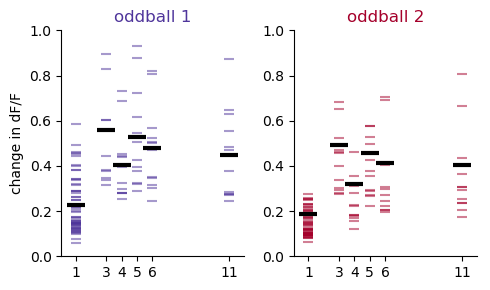

In [133]:
rows,cols = 1,2
figure(figsize=(2.5*cols,3*rows))

ax1 = subplot(rows,cols,1)
ylabel("change in dF/F")
ax2 = subplot(rows,cols,2)

stim_freq = [0,1,1,0]
c_ctr = 1
title_cols = [colors[4],colors[3]]

repetitions = []
possible_repeats = sort([1,5,3,6,4,11])
repetitions = zeros(length(possible_repeats),2)

ob_times = [oddball_1st,oddball_2nd]
ms_times = [ms_f2_times,ms_f1_times]

for r in [11,12]
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = sig_rois[r,:][1]
        df_per_fish = intersect(sr,valid_idx)

        subplot(rows,cols,c_ctr)
        #print(c_ctr)
        stims = vcat(ob_times[c_ctr],ms_times[c_ctr])
        for t in 2:length(stimtimes)
            onset = stimtimes[t]
            if (onset in stims) == true
                response = vec(mean(DF[df_per_fish,onset:onset+isi],dims=1))
                response = sum(response) .- response[1]
                prev_stim = stim_seq[t-1]
                curr_stim = stim_seq[t]

                repeats = findfirst(reverse(stim_seq[1:t-2]) .!== prev_stim)
                if isnothing(repeats) == true repeats = 11 end

                r_idx = findall(possible_repeats .== repeats)

                if (isnan(response) == false)
                    repetitions[r_idx,1] .+= 1
                    repetitions[r_idx,2] .+= response
                else 
                    print(repeats)
                end
                scatter(repeats,response,alpha=0.5,color=title_cols[c_ctr],s=50,marker="_")
                #end
            end
        end
    end
    
    for i = 1:size(repetitions)[1]
        y = repetitions[i,2]./repetitions[i,1]
        scatter(possible_repeats[i],y,color="black",s=150,marker="_",linewidth=3)
    end
    
    c_ctr += 1
end
    
titles = ["oddball 1","oddball 2"]
ctr = 1
for ax in [ax1,ax2]#,ax3,ax4]
    ax.set_ylim(0,1)
    ax.set_title(titles[ctr],color=title_cols[ctr])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    #ax.set_xlabel("previous stim repetition")
    ax.set_xticks(possible_repeats)
    #ax.set_xticklabels(["same","different","oddball 1", "oddball 2"],rotation=45)
    ctr+=1
end

tight_layout()

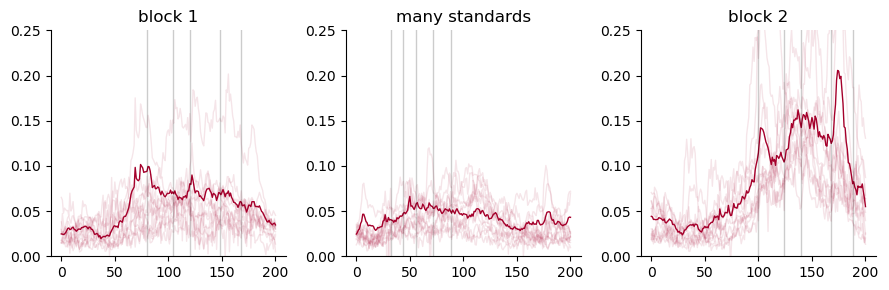

In [173]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

r = 12

#fish=unique(idx_fish)[1]
idx = findall(centroids[:,1] .> 1000)
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    sr = intersect(sr,idx)

    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[3],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = intersect(idx,sig_rois[r,:][1])
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[3],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f1_times[(f1_times .> rngs[t]) .&& (f1_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

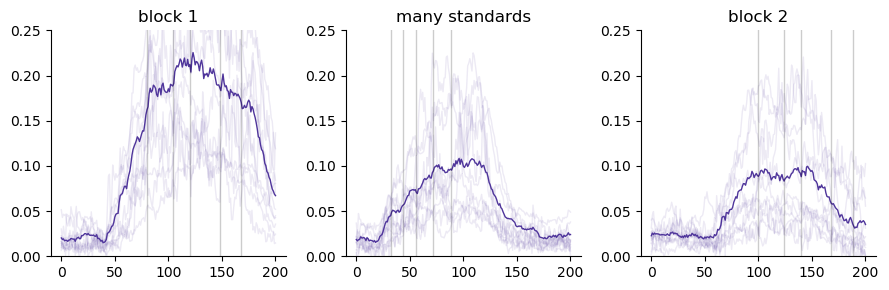

In [158]:
figure(figsize=(9,3))
ax1 = subplot(131)
ax2 = subplot(132)
ax3 = subplot(133)

titles = ["oddball","offset"]

n_fish = length(unique(idx_fish))

rngs = [200,600,900]

r = 11

#fish=unique(idx_fish)[1]
idx = findall(centroids[:,1] .> 1000)
for fish in unique(idx_fish)
    valid_idx = findall(idx_fish[1,:] .== fish)
    sr = sig_rois[r,:][1]
    or = sig_rois[r2,:][1]
    
    sr = intersect(sr,idx)

    df_per_fish = intersect(sr,valid_idx)
    for t = 1:3
        subplot(1,3,t)
        rng=rngs[t]:rngs[t]+200
        try
            avg = vec(mean(DF[df_per_fish,rng],dims=1))
            plot(avg,color=colors[4],linewidth=1,alpha=0.1)
        catch err
            print(err)
        end
    end
end

for t = 1:3
    subplot(1,3,t)
    rng=rngs[t]:rngs[t]+200
    sr = intersect(idx,sig_rois[r,:][1])
    avg = vec(mean(DF[sr,rng],dims=1))
    plot(avg,color=colors[4],linewidth=1)    
    for ob in oddball_times[(oddball_times .> rngs[t]) .&& (oddball_times .< rngs[t] + 200)]
        axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
    end
end

t = 2
subplot(1,3,t)
for ob in f1_times[(f1_times .> rngs[t]) .&& (f1_times .< rngs[t] + 200)]
    axvline((ob-rngs[t]),0,1,color="black",linewidth=1,alpha=0.2)
end

subplot(131); title("block 1")
subplot(132); title("many standards")
subplot(133); title("block 2")

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(0,0.25)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

### Plot average DF/F for oddball cells that are NOT also frequency responsive

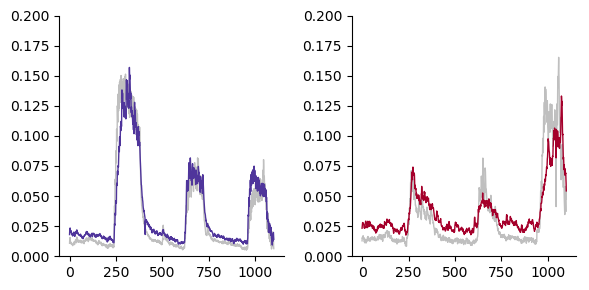

In [803]:
figure(figsize=(6,3))
ax1 = subplot(121)
ax2 = subplot(122)

ctr = 1
cctr = 3
titles = ["531 Hz","1148 Hz"]
subplot(121)

sr = sig_rois[7,:][1]
overlap = intersect(sig_rois[5,:][1],sr)
avg_overlap =  vec(mean(DF[overlap,:],dims=1))
plot(avg_overlap,color="black",linewidth=1,alpha=0.25)

sr_filt = []
for s in sr
    if (s in overlap) == false
        append!(sr_filt,s)
    end
end
avg_filt = vec(mean(DF[sr_filt,:],dims=1))
plot(avg_filt,color=colors[4],linewidth=1)

subplot(122)
sr = sig_rois[8,:][1]
overlap = intersect(sig_rois[6,:][1],sr)
avg_overlap =  vec(mean(DF[overlap,:],dims=1))
plot(avg_overlap,color="black",linewidth=1,alpha=0.25)

sr_filt = []
for s in sr
    if (s in overlap) == false
        append!(sr_filt,s)
    end
end

avg_filt = vec(mean(DF[sr_filt,:],dims=1))
plot(avg_filt,color=colors[3],linewidth=1)

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(0,0.2)
    ax.set_ylim(0,0.2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ctr+=1
end

tight_layout()

In [67]:
figure(figsize=(9,12)); 
suptitle("1s ISI")
a = 0.2

nr1 = nonsig_rois[6,:][1]; sr1 = sig_rois[6,:][1]
nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]

nr3 = nonsig_rois[5,:][1]; sr3 = sig_rois[5,:][1]
nr4 = nonsig_rois[8,:][1]; sr4 = sig_rois[8,:][1]
#or = intersect(sr2,sr3)

grid_size = 3

ax1 = subplot(3,3,1)
ax2 = subplot(3,3,2)
ax3 = subplot(3,3,3)
ax4 = subplot(3,3,4)
ax5 = subplot(3,3,5)
ax6 = subplot(3,3,6)
ax7 = subplot(3,3,7)
ax8 = subplot(3,3,8)
ax9 = subplot(3,3,9)


subplot(3,3,2); title("531 Hz")
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

subplot(3,3,3); title("1148 Hz")
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[4],s=1,alpha=a)

subplot(3,3,4); title("oddball 1")
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

subplot(3,3,7); title("oddball 2")
scatter(centroids[nr4,2],centroids[nr4,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr4,2],centroids[sr4,1],color=colors[3],s=1,alpha=a)

### 531 vs oddball 1
subplot(3,3,5)
idx = intersect(sr2,sr3)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 531 vs oddball 2
subplot(3,3,8)
idx = intersect(sr4,sr3)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 1148 vs oddball 1
subplot(3,3,6)
idx = intersect(sr2,sr1)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)

### 1148 vs oddball 2
subplot(3,3,9)
idx = intersect(sr4,sr1)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


ctr = 1
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

LoadError: UndefVarError: ymn not defined

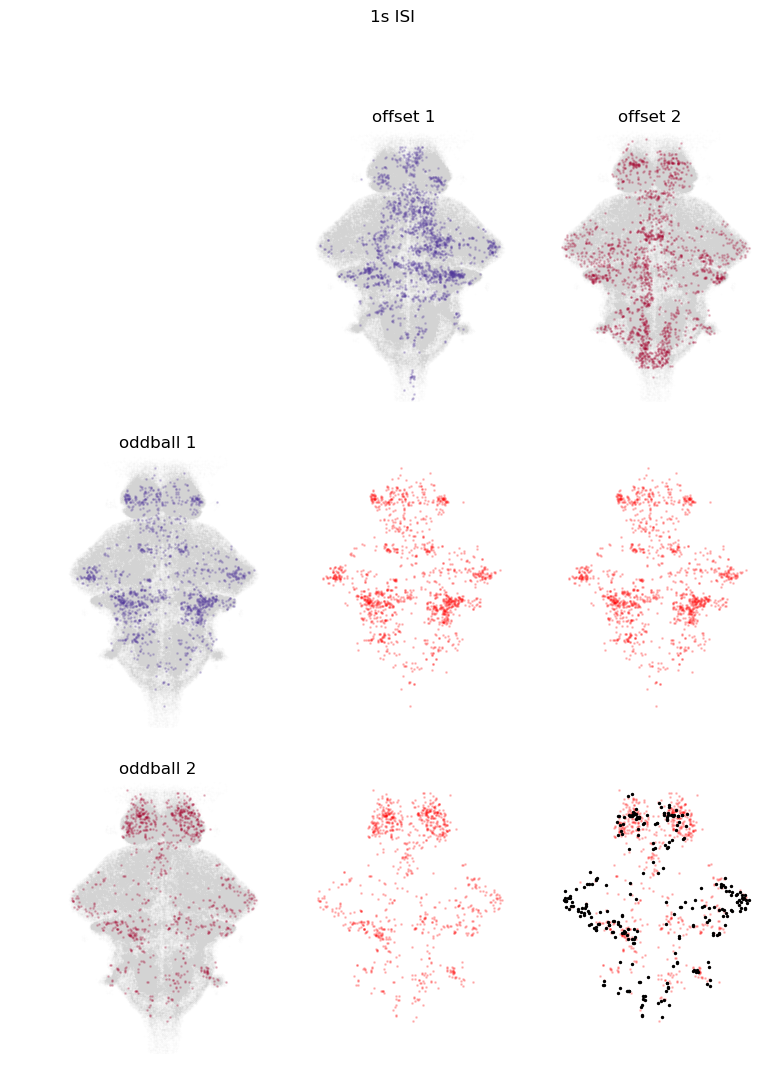

In [73]:
figure(figsize=(9,12)); 
suptitle("1s ISI")
a = 0.2

nr1 = nonsig_rois[10,:][1]; sr1 = sig_rois[10,:][1]
nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]

nr3 = nonsig_rois[9,:][1]; sr3 = sig_rois[9,:][1]
nr4 = nonsig_rois[8,:][1]; sr4 = sig_rois[8,:][1]

grid_size = 3

ax1 = subplot(3,3,1)
ax2 = subplot(3,3,2)
ax3 = subplot(3,3,3)
ax4 = subplot(3,3,4)
ax5 = subplot(3,3,5)
ax6 = subplot(3,3,6)
ax7 = subplot(3,3,7)
ax8 = subplot(3,3,8)
ax9 = subplot(3,3,9)

subplot(3,3,2); title("offset 1")
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

subplot(3,3,3); title("offset 2")
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[3],s=1,alpha=a)

subplot(3,3,4); title("oddball 1")
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

subplot(3,3,7); title("oddball 2")
scatter(centroids[nr4,2],centroids[nr4,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr4,2],centroids[sr4,1],color=colors[3],s=1,alpha=a)

### 531 vs oddball 1
subplot(3,3,5)
idx = intersect(sr2,sr3)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 531 vs oddball 2
subplot(3,3,8)
idx = intersect(sr4,sr3)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 1148 vs oddball 1
subplot(3,3,6)
idx = intersect(sr2,sr1)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)

### 1148 vs oddball 2
subplot(3,3,9)
idx = intersect(sr4,sr1)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)

ctr = 1
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

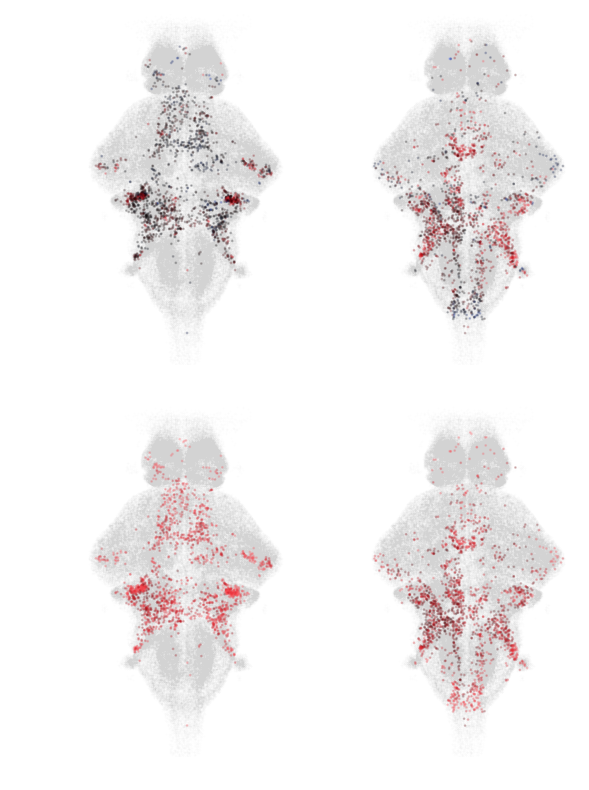

In [71]:
rows,cols = 2,2

figure(figsize=(cols*3,rows*4)); 
a = 0.2
vm = 0.1

nr1 = nonsig_rois[5,:][1]; sr1 = sig_rois[5,:][1]
nr2 = nonsig_rois[6,:][1]; sr2 = sig_rois[6,:][1]
c1_same = coeffs[8,sr1]; c1_diff = coeffs[7,sr1]
c2_same = coeffs[7,sr2]; c2_diff = coeffs[8,sr2];

ax1 = subplot(rows,cols,1)
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=c1_same,cmap=bwr_black,vmin=-vm,vmax=vm,s=1,alpha=a)

ax2 = subplot(rows,cols,2)
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],c=c2_same,cmap=bwr_black,vmin=-vm,vmax=vm,s=1,alpha=a)

ax3 = subplot(rows,cols,3)
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],c=c1_diff,cmap=bwr_black,vmin=-vm,vmax=vm,s=1,alpha=a)
ylabel("different frequency")

ax4 = subplot(rows,cols,4)
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],c=c2_diff,cmap=bwr_black,vmin=-vm,vmax=vm,s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

ax1.spines["left"].set_visible(true)
ax1.set_ylabel("same frequency")


tight_layout()

### Intersection anatomy plots

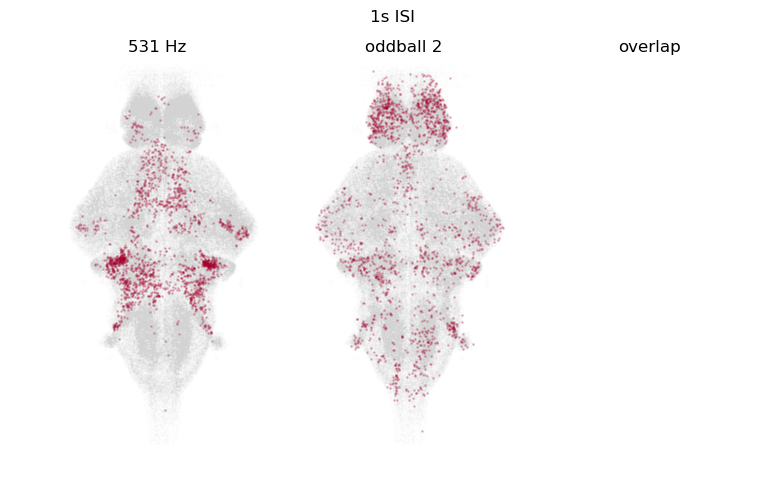

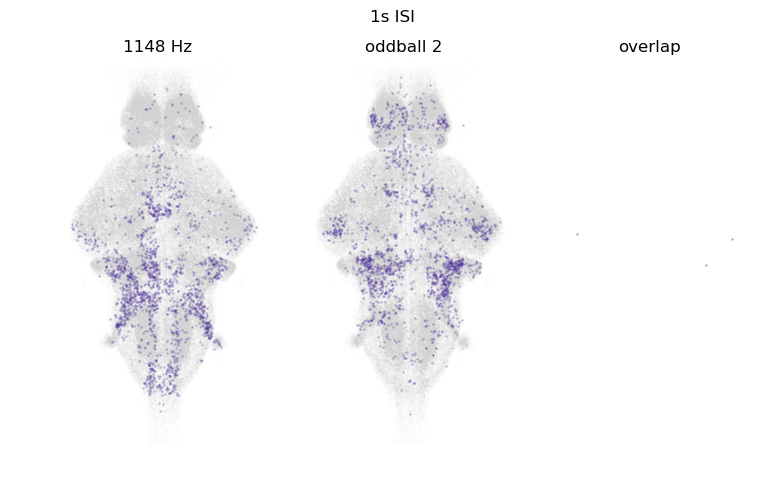

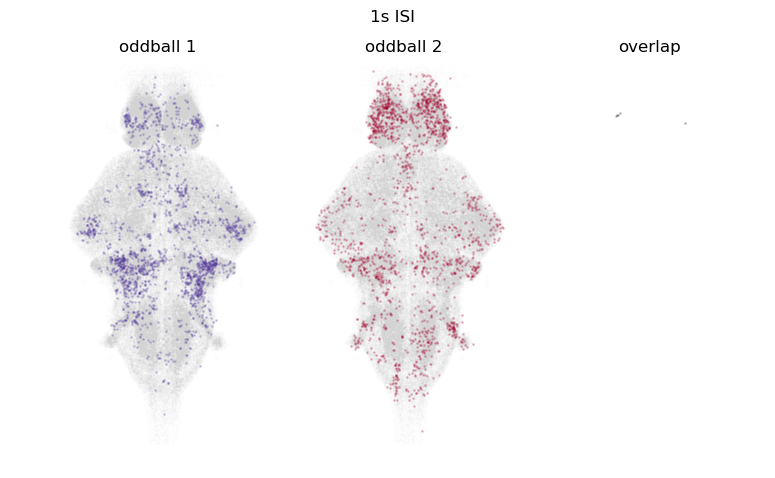

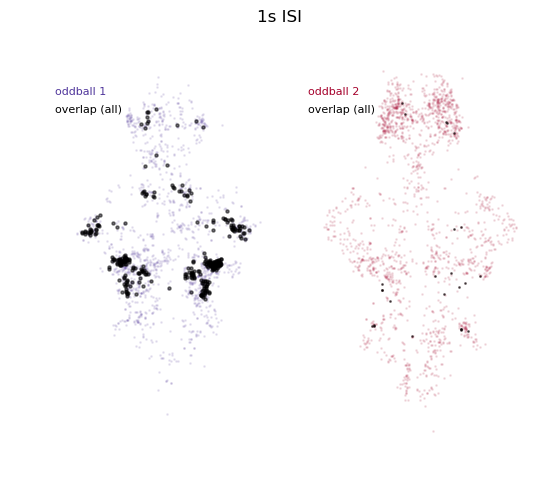

In [778]:
figure(figsize=(9,5)); 
suptitle("1s ISI")
a = 0.2

titles = ["531 Hz","oddball 2","overlap"]

nr2 = nonsig_rois[5,:][1]; sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

figure(figsize=(9,5)); 
suptitle("1s ISI")
a = 0.2

titles = ["1148 Hz","oddball 1","overlap"]

nr2 = nonsig_rois[6,:][1]; sr2 = sig_rois[6,:][1]
nr3 = nonsig_rois[7,:][1]; sr3 = sig_rois[7,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

figure(figsize=(9,5)); 
suptitle("1s ISI")
a = 0.2

titles = ["oddball 1","oddball 2","overlap"]

nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or = intersect(sr2,sr3)

ax2 = subplot(131);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(132);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(133);
scatter(centroids[or,2],centroids[or,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end


figure(figsize=(6,5)); 
suptitle("1s ISI")
a = 0.1

fs = 8
#titles = ["oddball 1/all oddball","oddball 2/all oddball",""]

nr1 = nonsig_rois[1,:][1]; sr1 = sig_rois[1,:][1]
nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]; sr3 = sig_rois[8,:][1]
or1 = intersect(sr1,sr2)
or2 = intersect(sr1,sr3)

ax2 = subplot(121);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[or1,2],centroids[or1,1],color="black",s=5,alpha=0.5)
text(0,1200,"oddball 1",color=colors[4],fontsize=fs)
text(0,1150,"overlap (all)",color="black",fontsize=fs)


ax3 = subplot(122);
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[or2,2],centroids[or2,1],color="black",s=1,alpha=0.5)
text(0,1200,"oddball 2",color=colors[3],fontsize=fs)
text(0,1150,"overlap (all)",color="black",fontsize=fs)

ctr = 1
for ax in [ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

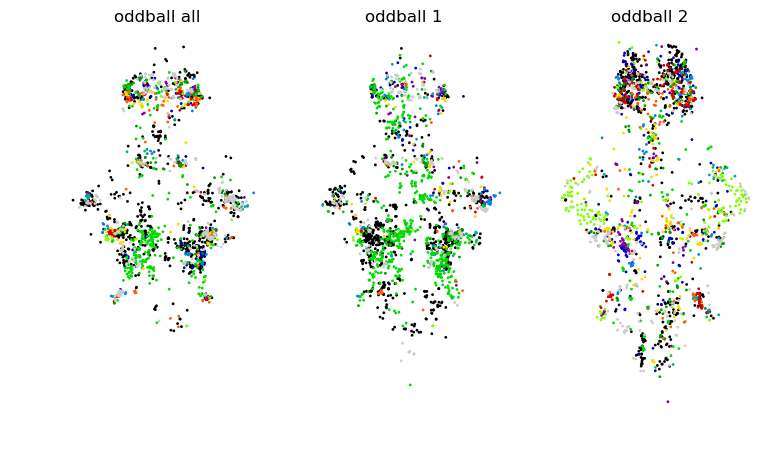

In [797]:
figure(figsize=(9,5))

cm = "nipy_spectral"

sr =  sig_rois[2,:][1]
sr1 = sig_rois[7,:][1]
sr2 = sig_rois[8,:][1]

ax1 = subplot(131); title("oddball all")
scatter(centroids[sr,2],centroids[sr,1],c=reset_idx_fish[sr]/n_fish,s=1,cmap=cm)

ax2 = subplot(132); title("oddball 1")
scatter(centroids[sr1,2],centroids[sr1,1],c=reset_idx_fish[sr1]/n_fish,s=1,cmap=cm)

ax3 = subplot(133); title("oddball 2")
scatter(centroids[sr2,2],centroids[sr2,1],c=reset_idx_fish[sr2]/n_fish,s=1,cmap=cm)

for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
end

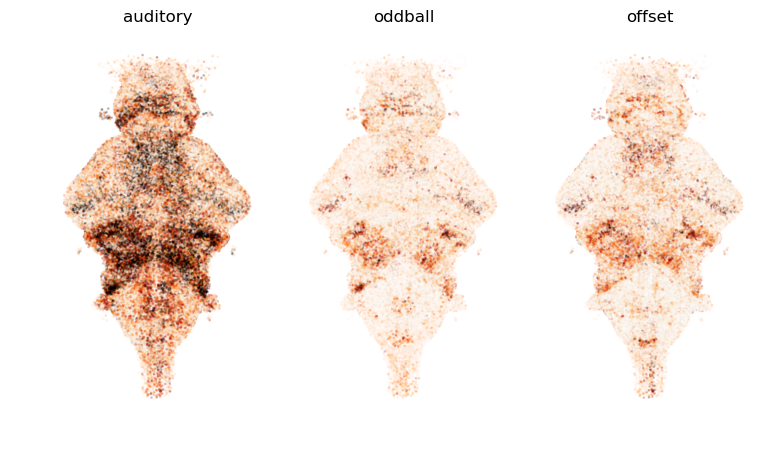

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff7dbe860>

In [394]:
figure(figsize=(9,5)); 
a = 0.2
vm = 0.2

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=r2s[1,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=r2s[2,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=r2s[3,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

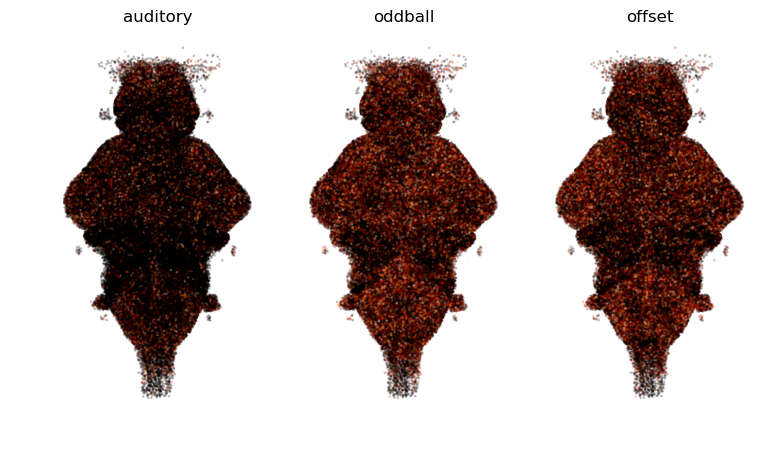

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff9043b00>

In [410]:
figure(figsize=(9,5)); 

a = 0.2
vm = 1

cm = "gist_heat"

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=pvals[1,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=pvals[2,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=pvals[3,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

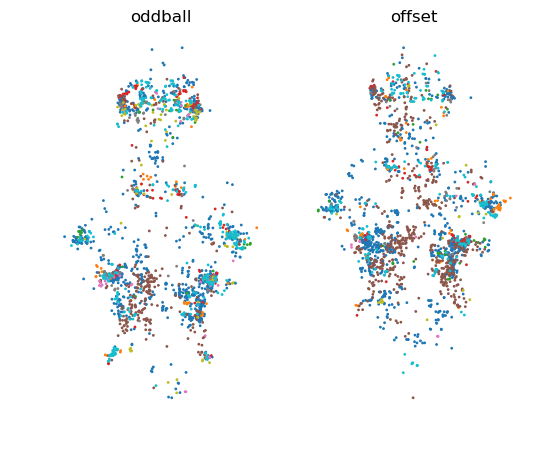

PyObject <matplotlib.collections.PathCollection object at 0x7f801dc95438>